<h2><center>Mortgage Approval Prediction using 2020 HMDA Dataset!</center></h2>

### Table of Contents

1. [Introduction](#1)

2. [Project Problem Framing](#2)

3. [Loading Libraries and Reading Data](#3)<br>
    a. [Loading Libraries](#31)<br>
    b. [Version of Installed Python Library](#32)<br>
    c. [Loading Data](#33)<br>

4. [Exploratory Data Analysis (EDA)](#4)<br>
    a. [Data Dimensionality](#41)<br>
    b. [Data Types](#42)<br>
    c. [Summary Statistics](#43)<br>
    d. [Check for Missing Values](#44)<br>
    e. [Explore Target Variable and its relationship with some predictor variables](#45)<br>
    f. [Detect Outliers and Anomalies](#46)<br>
    g. [Explore Additional Predictor Variables](#47)<br>
    
5. [Data Transformation and Preprocessing](#5)<br>
    a. [Data Transformation](#51)<br>
    &emsp;i. &nbsp;[Changing feature values to an integer and creating flags for 'Exempt'](#511)<br>
    &emsp;ii. [Creating calculated field 'calculated_loan_to_value_ratio'](#512)<br>
    &emsp;iii. [Fill blanks with zero for 'discount_points', 'lender_credits', 'aus-2', 'aus-3', 'aus-4', 'aus-5'](#513)<br>
    &emsp;iv.&nbsp;[Change values from '24-May' to '5-24' for feature 'total_units'](#514)<br>
    
    b. [Data Preprocessing](#52)<br>
    &emsp;i.&ensp; [Removing Denial Features](#521)<br>
    &emsp;ii.&nbsp; [Removing Features with just one unique value](#522)<br>
    &emsp;iii. [Removing Features which are identifiers](#523)<br>

6. [Feature Engineering](#6)<br>
    a. [Exploratory Feature Reduction](#61)<br>
    b. [Feature Selection](#62)<br>
    &emsp;i. &nbsp;[Find Features with high percentage of missing values](#621)<br>
    &emsp;ii. [ Find Features with single unique value](#622)<br>
    &emsp;iii. [Find Collinear Features](#623)<br>
    &emsp;iv.&nbsp;[Find Features with Zero Importance using GBM](#624)<br>
    &emsp;v.&nbsp;[Find Low Importance Features](#625)<br>
    &emsp;vi.&nbsp;[Removing Features](#626)<br>

7. [Model Development, Evaluation and Prediction](#7)<br>
    a. [Building Baseline Models with Default Params](#71)<br>
    b. [Hyperparameter Tuning & Model Comparison](#72)<br>
    c. [Model Evaluation on Test Data](#73)<br>
    d. [Model Prediction on Unseen Data](#74)

<a id="1"></a>
### 1. Introduction

The [FFIEC Home Mortgage Disclosure Act (HMDA)](https://ffiec.cfpb.gov/) requires many financial institutions to maintain, report, and publicly disclose information about mortgages.The dataset used for this project consists of information about 777,843 loans requested and their outcome on applicant alongwith other loan characterstics recorded by financial institutions in year 2020 for the state of Illinois.

<a id="2"></a>
### 2. Project Problem Framing

Nik, works for the US agency, Consumer Financial Protection Bureau, that regulates financial institutions. Nik's boss Rick, VP of loan regulation, has an upcoming presentation to financial institutions in the state of Illinois. VP of loan regulation found that it takes on avg 30.5 days to get a mortgage and carries a total cost of $13 billion annually to consumers and financial institutions. Nik has been tasked by the VP to explore the ways to speed up the mortgage approval process for certain applicants in order to reduce the administrative burden.

Nik has been specifically asked to asses whether:

- A model can be built, and what features should be included, and a discussion of performance of such model
- A model should be built, and a discussion of privacy and bias

The HMDA 2020 dataset provided for this analysis can be broadly categorized under the following:

__1. Geography:__ State, metropolitan area, county code and census tract of the property

__2. Property Characterstics:__ Property Type i.e. dervided dwelling category, property value, occupancy of property i.e. whether owner will use property as primary residence or not, construction method, whether property is manufactured home or land or both, total dwelling units on the property and how many of them are multifamily affordable units

__3. Loan Characterstics:__ Action taken on the Loan (whether originated or not), type of the loan, purpose of the Loan , loan’s lien statu, loan amount, interest rate, loan costs etc.

__4. Lender Characterstics:__ Financial institution legal entity to identify lender associated with the loan

__5. Applicant Characterstics:__ Includes some demographic information about applicant and co-applicant such as applicant and co-applicant age and their credit score type
This project utilizes applied machine learning methods, Regression as well as Ensemble methods, on the 2009 RECS dataset to achieve the following three objectives:

The target variable is "action_taken" which means action taken on the covered loan or application

<a id="3"></a>
### 3. Loading Libraries and Reading Data
<a id="31"></a>
#### a. Loading Libraries
Let's start by importing the libraries we need 

In [1]:
import pandas as pd
from pandas import set_option
from pandas import get_dummies
import numpy as np
import os
import time

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import scipy.stats

from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
import sklearn
import warnings
warnings.filterwarnings("ignore")

from feature_selector import FeatureSelector

#XGBoost libraries
import xgboost as xgb

<a id="32"></a>
#### b. Version of Installed Python Library 

For the purpose of reproducibility of this analysis, displaying the versions of installed libraries

In [2]:
print('matplotlib: {}'.format(matplotlib.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('seaborn: {}'.format(sns.__version__))
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('xgboost: {}'.format(xgb.__version__))


matplotlib: 3.6.1
sklearn: 1.0.2
seaborn: 0.12.0
pandas: 1.3.5
numpy: 1.22.4
xgboost: 1.6.1


<a id="33"></a>
#### c. Loading Data

In [3]:
DATA_PATH = 'data'
FILE_NAME = 'state_IL_applicant.csv'
df = pd.read_csv(os.path.join(DATA_PATH, FILE_NAME), encoding = 'utf-8-sig')

<a id="4"></a>
### 4. Exploratory Data Analysis (EDA)

In the EDA phase, we will perform initial investigations on the dataset to check the following:
- data dimensionality (or shape) alongwith observing first few observations of the dataset
- data types (whether categorical or numerical)
- generate summary statistics
- missing values
- explore our target variable _'action_taken'_ and its possible predictors from the dataset
- detect outliers and anomalies
- explore additional predictor variables

<a id="41"></a>
#### a. Data Dimensionality

Let's start by glancing first few observations of the 2020 Home Mortgage Disclosure Act (HMDA) dataset alongwith its dimensionality

In [4]:
pd.options.display.max_columns = df.shape[1]
df.head()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,loan_amount,loan_to_value_ratio,interest_rate,rate_spread,hoepa_status,total_loan_costs,total_points_and_fees,origination_charges,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization,interest_only_payment,balloon_payment,other_nonamortizing_features,property_value,construction_method,occupancy_type,manufactured_home_secured_property_type,manufactured_home_land_property_interest,total_units,multifamily_affordable_units,income,debt_to_income_ratio,applicant_credit_score_type,co-applicant_credit_score_type,applicant_age,co-applicant_age,applicant_age_above_62,co-applicant_age_above_62,submission_of_application,initially_payable_to_institution,aus-1,aus-2,aus-3,aus-4,aus-5,denial_reason-1,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2020,549300AG64NHILB7ZP05,20994,IL,17093.0,1.709389e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,1,1,2,1,32,1,2,2,2,245000,80,2.99,0.368,2,2343.36,NaN,1245,NaN,1022.36,180,NaN,NaN,2,2,2,2,305000,1,1,3,5,1,NaN,199.0,30%-<36%,1,9,55-64,55-64,No,No,1,1,2,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,27626,26.05,92900,121,7369,8696,12
1,2020,254900RAPDJZFI07WS81,99999,IL,17099.0,1.709996e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,1,0,2,1,1,1,1111,1111,1111,55000,Exempt,Exempt,Exempt,3,Exempt,Exempt,Exempt,Exempt,Exempt,Exempt,Exempt,Exempt,1111,1111,1111,1111,Exempt,1,3,1111,1111,1,Exempt,4.0,Exempt,1111,1111,25-34,9999,No,NaN,1111,1111,1111,NaN,NaN,NaN,NaN,1111,NaN,NaN,NaN,4896,13.81,65800,99,1546,2186,59
2,2020,549300LYRWPSYPK6S325,99999,IL,17187.0,1.718787e+10,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,5,0,2,2,31,1,2,2,2,105000,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,360,NaN,NaN,2,2,2,2,NaN,1,1,3,5,1,NaN,NaN,NaN,9,9,45-54,45-54,No,No,1,1,6,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,5061,29.20,65800,74,1359,2008,74
3,2020,549300YOESI1GLKRL151,16984,IL,17197.0,1.719788e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,4,0,2,1,1,1,2,2,1,95000,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,360,NaN,NaN,2,2,2,2,NaN,1,3,3,5,1,NaN,140.0,NaN,9,9,45-54,9999,No,NaN,1,1,1,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,4958,62.46,84800,80,1236,1674,39
4,2020,549300GS0W0TEUQS8571,16984,IL,17043.0,1.704385e+10,NC,Conventional:First Lien,Single Family (1-4 Units):Site-Built,1,0,2,1,1,1,2,2,2,645000,89.64,3.35,-0.023,2,5588.65,NaN,815,NaN,800,360,NaN,NaN,2,2,2,2,725000,1,1,3,5,1,NaN,131.0,36,2,10,25-34,9999,No,NaN,1,1,6,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,3369,9.20,84800,285,888,1083,58


In [5]:
print(f"Shape of the HMDA dataset is {df.shape}")

Shape of the HMDA dataset is (777843, 68)


As can be seen above, HMDA 2020 dataset consists of 777,843 observations and 68 features. Let's explore how many of these features are categorical vs numerical

<a id="42"></a>
#### b. Data Types

In [6]:
num_features = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(num_features))

cat_features = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(cat_features))

Number of Numerical features:  44
Number of Categorical features:  24


`df.info()` method prints a concise summary of a dataframe including count of index data type, number of columns. `df.describe()` method prints out the descriptive statistics including mean, median (i.e. Second Quartile, Q2 depicted by 50% in the summary table below), standard deviation, range, Q1 and Q3 quartile values. As can be seen below, HMDS 2020 dataset consists of three different column data types:
- _float64_ data type with 11 columns
- _int64_ data type with 33 columns, and 
- _object_ data type with 24 columns

The count of column data types is consistent with the count of numerical and categorical features we calculated above. Count of Numerical features we calculated above is actually sum of number of _float64_ and _int64_ data type columns i.e. (11 + 33 = 44). 

The number of records, 777,843 is consistent with what we found using `df.shape`. We have missing values in the dataset. As you can see in the code output below, the features 'county_code', 'census_tract', 'conforming_loan_limit', 'loan_to_value_ratio', 'interest_rate', 'rate_spread', 'total_loan_costs', 'total_points_and_fees', 'origination_charges', 'discount_points', 'lender_credits', 'loan_term', 'prepayment_penalty_term', 'intro_rate_period', 'property_value', 'multifamily_affordable_units', 'income', 'debt_to_income_ratio', 'applicant_age_above_62', 'co-applicant_age_above_62' have missing values. The features 'aus-2', 'aus-3', 'aus-4' and 'aus-5' though looks to have missing values in them, however, after reading through the data field explanation, it was assumed that the feature 'aus' i.e. automated underwriting system that the financial institution used to evaluate the loan application was broken down into five separate features since a financial institution might have used more than one automated underwriting system to evaluate a loan application. 

Lastly, as per the project instructions, we would exclude the features 'denial_reason-1', 'denial_reason-2', 'denial_reason-3', 'denial_reason-4' from our project analysis.


In [7]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777843 entries, 0 to 777842
Data columns (total 68 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   activity_year                             777843 non-null  int64  
 1   lei                                       777843 non-null  object 
 2   derived_msa-md                            777843 non-null  int64  
 3   state_code                                777843 non-null  object 
 4   county_code                               774943 non-null  float64
 5   census_tract                              774726 non-null  float64
 6   conforming_loan_limit                     774760 non-null  object 
 7   derived_loan_product_type                 777843 non-null  object 
 8   derived_dwelling_category                 777843 non-null  object 
 9   action_taken                              777843 non-null  int64  
 10  purchaser_type      

<a id="43"></a>
#### c. Summary Statistics

In [8]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,activity_year,derived_msa-md,county_code,census_tract,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,loan_amount,hoepa_status,negative_amortization,interest_only_payment,balloon_payment,other_nonamortizing_features,construction_method,occupancy_type,manufactured_home_secured_property_type,manufactured_home_land_property_interest,income,applicant_credit_score_type,co-applicant_credit_score_type,submission_of_application,initially_payable_to_institution,aus-1,aus-2,aus-3,aus-4,aus-5,denial_reason-1,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
count,777843.00000,777843.00000,774943.00000,774726.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,672272.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,56461.00000,12336.00000,1675.00000,1336.00000,777843.00000,12168.00000,1701.00000,139.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000,777843.00000
mean,2020.00000,25994.44486,17079.62011,17080281447.48188,2.37280,4.30599,1.98915,1.26223,19.42522,1.04888,55.83754,55.80307,55.67267,244203.79177,2.33986,55.79857,55.76559,55.78718,55.79499,1.00717,1.10584,56.77837,58.67178,225.72691,58.58793,62.01276,55.17121,55.17744,56.85661,3.00689,3.23079,1.44716,1.44087,47.63049,4.52285,5.54086,6.47482,5516.77885,30.15541,84263.14423,122.36661,1503.86650,1768.03163,42.93323
std,0.00000,20269.84353,58.77308,64833103.43235,1.82917,13.91990,0.10361,0.58671,14.55270,0.21561,238.34579,238.38684,238.06112,666979.29067,0.47419,238.26170,238.26921,238.26429,238.26251,0.08436,0.43736,238.12667,237.69908,4642.95013,237.55995,236.77479,238.40429,238.40301,238.12539,1.71714,1.60016,0.74858,0.74317,201.70324,2.68180,2.68267,2.31983,3172.42827,24.69627,9598.39580,46.74958,941.89776,1045.55976,19.38769
min,2020.00000,0.00000,17001.00000,17001000100.00000,1.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,5000.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,-25785.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,2020.00000,16984.00000,17031.00000,17031804705.00000,1.00000,0.00000,2.00000,1.00000,1.00000,1.00000,2.00000,2.00000,2.00000,125000.00000,2.00000,2.00000,2.00000,2.00000,2.00000,1.00000,1.00000,3.00000,5.00000,62.00000,2.00000,9.00000,1.00000,1.00000,1.00000,1.00000,2.00000,1.00000,1.00000,10.00000,3.00000,4.00000,5.00000,3732.00000,11.97000,84800.00000,93.00000,962.00000,1191.00000,28.00000
50%,2020.00000,16984.00000,17043.00000,17043845805.00000,1.00000,1.00000,2.00000,1.00000,31.00000,1.00000,2.00000,2.00000,2.00000,205000.00000,2.00000,2.00000,2.00000,2.00000,2.00000,1.00000,1.00000,3.00000,5.00000,97.00000,3.00000,9.00000,1.00000,1.00000,2.00000,2.00000,2.00000,1.00000,1.00000,10.00000,4.00000,5.00000,6.00000,4887.00000,22.90000,84800.00000,117.00000,1339.00000,1609.00000,41.00000
75%,2020.00000,29404.00000,17111.00000,17111871500.00000,4.00000,3.00000,2.00000,1.00000,31.00000,1.00000,2.00000,2.00000,2.00000,295000.00000,3.00000,2.00000,2.00000,2.00000,2.00000,1.00000,1.00000,3.00000,5.00000,150.00000,9.00000,10.00000,2.00000,1.00000,6.00000,5.00000,5.00000,2.00000,2.00000,10.00000,6.00000,9.00000,9.00000,6350.00000,41.16000,84800.00000,145.00000,1805.00000,2091.00000,58.00000
max,2020.00000,99999.00000,17203.00000,29189218102.00000,8.00000,72.00000,2.00000,4.00000,32.00000,2.00000,1111.00000,1111.00000,1111.00000,230000000

**Key Observations:**
- Mean value is different (i.e. more or less) than median value for features 'income', 'tract_minority_population_percent'
- Large difference in 75th percentile and maximum value for columns 'loan_amount, 'income', 'tract_population', 'tract_minority_population_percent', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes'
- Thus, these observations mean that there are outier values in our dataset

Now, let's check the summary statistics for categorical features

In [9]:
df.describe(include=['object'])

,lei,state_code,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,loan_to_value_ratio,interest_rate,rate_spread,total_loan_costs,total_points_and_fees,origination_charges,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,property_value,total_units,multifamily_affordable_units,debt_to_income_ratio,applicant_age,co-applicant_age,applicant_age_above_62,co-applicant_age_above_62
count,777843,777843,774760,777843,777843,525601,567645,457513,503755,39415,504789,153156,248673,773349,48574,93853,621097,777843,39139,518773,777843,777843,710925,314933
unique,1134,1,2,7,4,61345,2541,31578,206927,1248,97026,68567,73909,561,13,63,746,9,31,20,8,9,2,2
top,549300U3721PJGQZYY68,IL,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,80,2.875,Exempt,Exempt,Exempt,0,Exempt,Exempt,360,Exempt,Exempt,Exempt,1,Exempt,20%-<30%,35-44,9999,No,No
freq,42410,777843,746025,589274,769212,49658,52936,38824,37466,37466,52197,37466,37466,515176,37444,37437,37460,746925,37622,118333,206294,405552,613329,269594


In the table above, we can see the number of unique values as well as the top value and it's frequency for all the categorical features. 

**Below are the key observations from the above displayed summary statistics of categorical variables:**
- Some of the features were actually numerical, however presence of text entry 'Exempt' converted them into categorical. These features are: 'loan_to_value_ratio', 'interest_rate', 'rate_spread', 'total_loan_costs', 'total_points_and_fees', 'origination_charges', 'discount_points', 'lender_credits', 'loan_term', 'prepayment_penalty_term', 'intro_rate_period', 'property_value', 'multifamily_affordable_units', 'debt_to_income_ratio'
- After reading through the [FFIEC HMDA 2020 Guide] (https://www.ffiec.gov/hmda/pdf/2020Guide.pdf), it was found that according to FFIEC HMDA 2018 Act, certain loan transactions or applications made by certain depository institutions and insured credit unions were covered by a partial exemption and thus they were exempted from collecting, recording and reporting 26 specific data points for that particular transaction
- The feature 'debt_to_income_ratio' consists of values which are integers like 36, 37 as well as data values mentioned in range such as '30%-<36%', '20%-<30%'. We will convert 'debt_to_income' feature back to integer later in the data preprocessing and transformation section

Let's now inspect the 'Exempt' values in each of the features identified above ('loan_to_value_ratio', 'interest_rate', 'rate_spread', 'total_loan_costs', 'total_points_and_fees', 'origination_charges', 'discount_points', 'lender_credits', 'loan_term', 'prepayment_penalty_term', 'intro_rate_period', 'property_value', 'multifamily_affordable_units', 'debt_to_income_ratio') and get a count of the values.

In [10]:
cat_features_with_Exempt = ['loan_to_value_ratio', 'interest_rate', 'rate_spread', 'total_loan_costs', 'total_points_and_fees', 'origination_charges', 'discount_points', 
'lender_credits', 'loan_term', 'prepayment_penalty_term', 'intro_rate_period', 'property_value', 'multifamily_affordable_units', 'debt_to_income_ratio']

for col in cat_features_with_Exempt:
    print('{} has {} Exempt values'.format(col, df[col].value_counts()['Exempt']))
    print('----------------------------------')

loan_to_value_ratio has 37440 Exempt values
----------------------------------
interest_rate has 37440 Exempt values
----------------------------------
rate_spread has 38824 Exempt values
----------------------------------
total_loan_costs has 37466 Exempt values
----------------------------------
total_points_and_fees has 37466 Exempt values
----------------------------------
origination_charges has 37466 Exempt values
----------------------------------
discount_points has 37466 Exempt values
----------------------------------
lender_credits has 37466 Exempt values
----------------------------------
loan_term has 37440 Exempt values
----------------------------------
prepayment_penalty_term has 37444 Exempt values
----------------------------------
intro_rate_period has 37437 Exempt values
----------------------------------
property_value has 37460 Exempt values
----------------------------------
multifamily_affordable_units has 37622 Exempt values
----------------------------------
d

It can be seen from the above output that all the features have more than 37,000 transactions marked as 'Exempt' as per the requirement of [FFIEC HMDA 2020 Guide] (https://www.ffiec.gov/hmda/pdf/2020Guide.pdf). Since, these transaction values doesn't show the actual values for their respective features and hence we can either create a separate binary column for these features and mark 1 in this new binary column if 'Exempt' exists in actual feature value, otherwise 0 and simultaneously change text 'Exempt' to 0 in the actual feature values or else we may exclude these transactions from our dataset since these observations might not be useful in model training and development. We will see in the later section if creating new binary feature out of these features would add predictive power to our model or not. 

Let's first find out how many transactions in total we have in our dataset for which 'Exempt' has been marked in each of the above features discussed: 

In [11]:
df_exempt = df[(df == 'Exempt').any(axis =1)==1]
print("Total number of transactions marked as 'Exempt':", len(df_exempt))
print("Proportion of transactions marked as 'Exempt': {} %".format(round(len(df_exempt)/len(df)*100,2)))

Total number of transactions marked as 'Exempt': 39080
Proportion of transactions marked as 'Exempt': 5.02 %


We have 39,080 transactions or rows being marked as 'Exempt', which is roughly 5% of the total dataset.

**Note:** In the above calculation of proportion of total transactions being marked as 'Exempt', the actual categorical features with one of the labels coded as '1111 -Exempt' has not been included since these features can be dealt by transforming them to one hot encodings and hence having 'Exempt' value for such variables as an additional feature

Let's now check the unique value counts for the remaining categorical features:

In [12]:
cat_features_remaining = list(set(list(cat_features))-set(list(df_exempt.columns[df_exempt.isin(['Exempt']).any()])))
print('Remaining categorical features:')
print(cat_features_remaining)

Remaining categorical features:
['applicant_age', 'co-applicant_age_above_62', 'derived_loan_product_type', 'total_units', 'state_code', 'conforming_loan_limit', 'co-applicant_age', 'derived_dwelling_category', 'applicant_age_above_62', 'lei']


In [13]:
pd.set_option('display.max_rows', 1000)
for col in cat_features_remaining:
    print(df[col].value_counts(), '\n');

35-44    206294
45-54    159618
25-34    149768
55-64    107209
8888      66918
65-74     54065
>74       17845
<25       16126
Name: applicant_age, dtype: int64 

No     269594
Yes     45339
Name: co-applicant_age_above_62, dtype: int64 

Conventional:First Lien          589274
FHA:First Lien                   102941
VA:First Lien                     42128
Conventional:Subordinate Lien     37747
FSA/RHS:First Lien                 5480
FHA:Subordinate Lien                206
VA:Subordinate Lien                  67
Name: derived_loan_product_type, dtype: int64 

1          746925
2           19070
3            5656
4            3109
24-May       2279
25-49         388
50-99         208
>149          109
100-149        99
Name: total_units, dtype: int64 

IL    777843
Name: state_code, dtype: int64 

C     746025
NC     28735
Name: conforming_loan_limit, dtype: int64 

9999     405552
35-44     92423
45-54     69134
25-34     65586
8888      57358
55-64     48967
65-74     26032
>74     

We can observe from the above value counts for features 'lei', 'state_code' and 'total_units' that there are 1134 unique values for feature 'lei' i.e. a total of 1134 financial institution transactions were logged in the 2020 HMDA dataset. Upon closely inspecting unique values for feature 'total_units', it can be observed that one of the value label '5-24' got transformed into a date format '24-May'. Whereas the feature 'state_code' has only one unique entry 'IL' which stands for 'Illinois'.

We can also check how values in each of the categorical features are distributed using argument `normalize = True` inside method `value_counts()` distribution of the unique value counts

In [14]:
for col in cat_features_remaining:
    print(round(df[col].value_counts(normalize= True)*100), '\n')

35-44    27.0
45-54    21.0
25-34    19.0
55-64    14.0
8888      9.0
65-74     7.0
>74       2.0
<25       2.0
Name: applicant_age, dtype: float64 

No     86.0
Yes    14.0
Name: co-applicant_age_above_62, dtype: float64 

Conventional:First Lien          76.0
FHA:First Lien                   13.0
VA:First Lien                     5.0
Conventional:Subordinate Lien     5.0
FSA/RHS:First Lien                1.0
FHA:Subordinate Lien              0.0
VA:Subordinate Lien               0.0
Name: derived_loan_product_type, dtype: float64 

1          96.0
2           2.0
3           1.0
4           0.0
24-May      0.0
25-49       0.0
50-99       0.0
>149        0.0
100-149     0.0
Name: total_units, dtype: float64 

IL    100.0
Name: state_code, dtype: float64 

C     96.0
NC     4.0
Name: conforming_loan_limit, dtype: float64 

9999     52.0
35-44    12.0
45-54     9.0
25-34     8.0
8888      7.0
55-64     6.0
65-74     3.0
>74       1.0
<25       1.0
Name: co-applicant_age, dtype: float64 

It can be observed from the above output that the feature 'state_code', has all the data being marked under a single data value. Hence, we can conclude that there is not enough variance in values of features 'state_code' and thus this feature would have no predictive power over the outcome variable 'action_taken' and we can safely drop this feature from the dataset in the feature selection section.

the other features such as 'total_units', 'derived_dwelling_category' and 'conforming_loan_limit' had 95% of the responses being marked under a single data value. We will explore these variables in depth in the later section.

<a id="44"></a>
#### d. Check for Missing Values

Let's now check how many missing values we have in each of the features

In [15]:
#pd.options.display.max_rows = 400000 #uncomment this line to see truncated contents of the output
df.isnull().sum()

activity_year                                    0
lei                                              0
derived_msa-md                                   0
state_code                                       0
county_code                                   2900
census_tract                                  3117
conforming_loan_limit                         3083
derived_loan_product_type                        0
derived_dwelling_category                        0
action_taken                                     0
purchaser_type                                   0
preapproval                                      0
loan_type                                        0
loan_purpose                                     0
lien_status                                      0
reverse_mortgage                                 0
open-end_line_of_credit                          0
business_or_commercial_purpose                   0
loan_amount                                      0
loan_to_value_ratio            

From the ouput above, we can see that we have some features for which majority of the values are missing. 

The features 'aus-2', 'aus-3', 'aus-4' and 'aus-5' though looks to have missing values in them, however, after reading through the data field explanation, it was assumed that the feature 'aus' i.e. automated underwriting system that the financial institution used to evaluate the loan application was broken down into five separate features since a financial institution might have used more than one automated underwriting system to evaluate a loan application. 

For feature 'loan_to_value_ratio', we will make a calculated field by dividing 'loan_amount' with feature 'property_value' in order to validate and fill some of the missing observations.

Additionally, as per the project instructions, we would exclude the features 'denial_reason-1', 'denial_reason-2', 'denial_reason-3', 'denial_reason-4' from our project analysis.

Rest of the features will be dealt during model building exercise by making use of `sklearn's` `SimpleImputer` class

Let's check how many features in total have more than 80% of the data missing

In [16]:
na_col_names = df.columns[(df.isna().sum()) > round(df.shape[0]*0.80)]
print('{} features have more than 80% of the responses missing'.format(len(na_col_names)),"\n" "Here's the name of the features:" "\n", list(na_col_names))

12 features have more than 80% of the responses missing 
Here's the name of the features:
 ['total_points_and_fees', 'discount_points', 'prepayment_penalty_term', 'intro_rate_period', 'multifamily_affordable_units', 'aus-2', 'aus-3', 'aus-4', 'aus-5', 'denial_reason-2', 'denial_reason-3', 'denial_reason-4']


- 12 features were found to have more than 80% of the data missing. The potential reason for missing values for features 'aus-2', 'aus-3', 'aus-4' and 'aus-5' has already been discussed in depth above
- For the remaining features 'total_points_and_fees', 'discount_points', 'prepayment_penalty_term', 'intro_rate_period', 'multifamily_affordable_units', the [FFIEC HMDA 2020 Guide] (https://www.ffiec.gov/hmda/pdf/2020Guide.pdf) was referred to check the definition of features and what values can they hold. It was found under the filing instructions for features 'discount_points' and 'lender_credits' that if no discount_points or lender_credits were provided, then these feature values will be blank. Hence, later in the data transform and preprocessing section we can safely transform the blank values to 0
- Since, the remainder of the features 'total_points_and_fees', 'prepayment_penalty_term', 'intro_rate_period', 'multifamily_affordable_units' have majority of the data values missing, it can be safely concluded that these features would have negligible or almost no predictive power over the outcome variable. In the later part of this project, we will drop these features from our final list of features

<a id="45"></a>
#### e. Explore Target Variable and its relationship with some predictor variables

Let's explore our target variable _'action_taken'_ and extract important features which are highly correlated with the target variable

In [17]:
df['action_taken'].describe()

count    777843.00000
mean          2.37280
std           1.82917
min           1.00000
25%           1.00000
50%           1.00000
75%           4.00000
max           8.00000
Name: action_taken, dtype: float64

Few key insights by looking at summary statistics of the dependent variable are as follows:
- Target variable _'action_taken'_ is a discrete numeric variable in nature with values ranging from 1 to 8

[Text(0, 0, '457462'),
 Text(0, 0, '15283'),
 Text(0, 0, '79081'),
 Text(0, 0, '102243'),
 Text(0, 0, '32455'),
 Text(0, 0, '90503'),
 Text(0, 0, '398'),
 Text(0, 0, '418')]

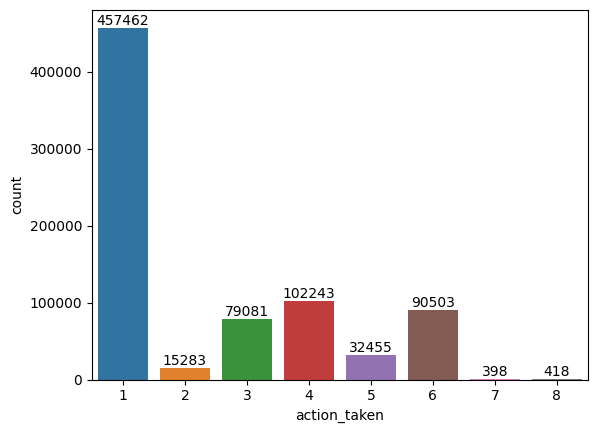

In [18]:
# cat = ['Loan originated', 'Application approved but not accepted', 'Application denied', 'Application withdrawn by applicant', 'File closed for incompleteness', 
# 'Purchased loan', 'Preapproval request denied', 'Preapproval request approved but not accepted']

ax = sns.countplot(x='action_taken', data=df)
ax.bar_label(ax.containers[0])

The target variable 'action_taken' has 8 discrete values. Hence, we will categorize these 8 values into two broad categories 1 i.e. Loan Originated and 0 for Loan not originated. The value 1 in 'action_taken' will be kept as such whereas we convert value greater than 1 to 0. Let's define a function in which we mark the Loans which were originated as 1 and the Loans which were NOT originated as 0

In [19]:
def recode_action_taken(y):
    if ( y == 1):
        return 1
    else:
        return 0
df['action_taken'] = df['action_taken'].apply(recode_action_taken)

Let's replot the bar graph we saw above with the new updated categories for 'action_taken' feature

[Text(0, 0, '320381'), Text(0, 0, '457462')]

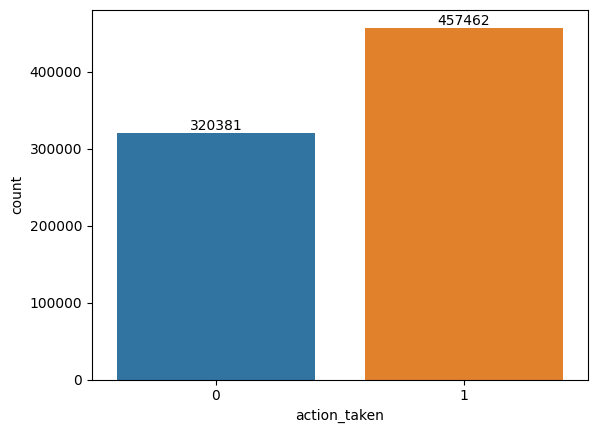

In [20]:
ax = sns.countplot(x='action_taken', data=df)
ax.bar_label(ax.containers[0])

It can be seen from the graph above that the distribution of target variable is in a approximately 60:40 proportion. Hence, we can safely conclude that our target variable has balanced data and does not suffer from class imbalance problem.

Let's now segment our data into groups and observe the relationship between categorical and numeric features. We will use Seaborn's boxplot to observe which target class is most affected by which of the numeric features

In [21]:
num_cols = ['loan_amount', 'income', 'tract_population', 'tract_minority_population_percent', 'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage', 
            'tract_owner_occupied_units', 'tract_one_to_four_family_homes', 'tract_median_age_of_housing_units']

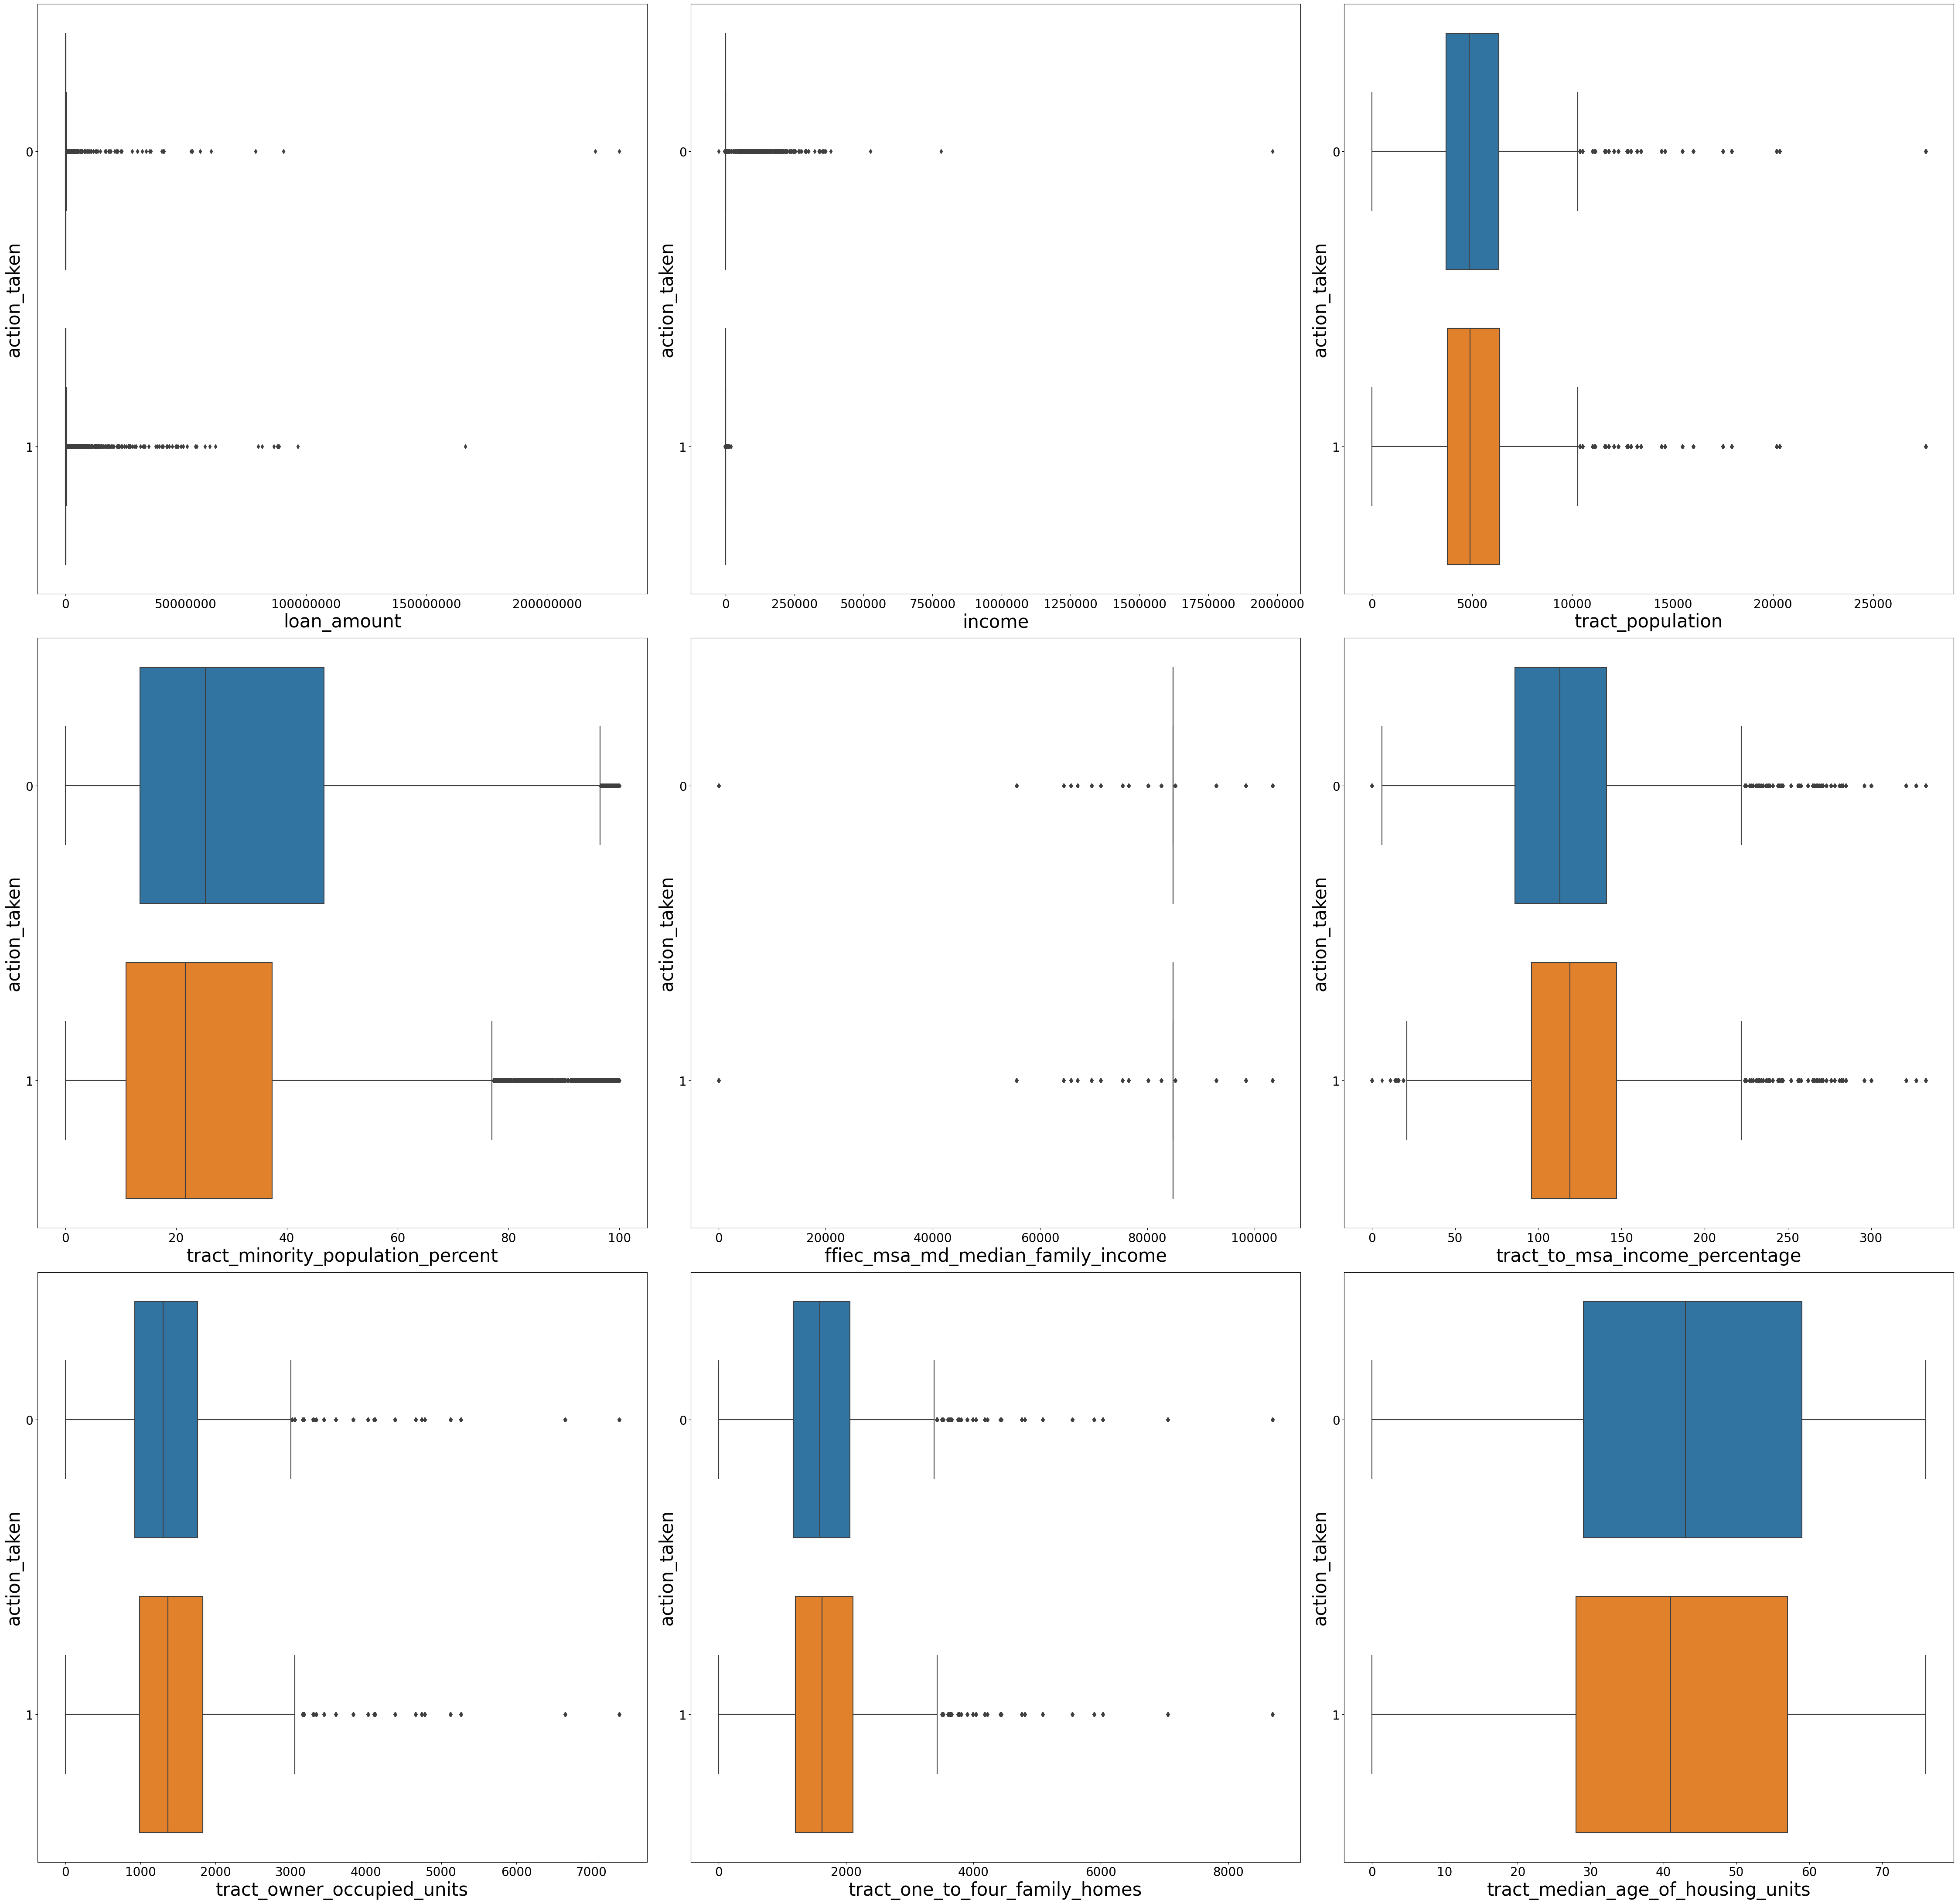

In [22]:
number_of_columns=3
number_of_rows = 4
plt.figure(figsize=(15*number_of_columns, 18*number_of_rows))
for i in range(0,len(num_cols)):
    plt.subplot(round(number_of_rows + 1),number_of_columns,i+1)
    #sns.set_style('whitegrid')
    sns.boxplot(y =df['action_taken'].astype('category'), x = df[num_cols[i]], data = df)
    plt.xlabel(num_cols[i], size = 30)
    plt.ylabel('action_taken', size = 30)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.ticklabel_format(style='plain', axis='x')
    plt.tight_layout()

We can see that 'tract_population', 'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes' and 'tract_median_age_of_housing_units' are equally distributed among transactions where loan was originated (target value 1) and where loan was not originated (target value 0). This means that these features might not be a good predictor for the target. However, we see that where 'loan_amount' or 'income' was higher the loan was not originated and higher the minority population of a tract was, less number of loans were originated and hence we may conclude from box plots that 'loan_amount', 'income' and 'tract_minority_population_percent' could be good predictors of the target variable.

<a id="46"></a>
#### f. Detect Outliers and Anomalies

Previously, in the summary statistics section, we found that the mean value was different from the median value for the features 'loan_amount', 'income', 'tract_population', 'tract_minority_population_percent', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes'. In addition, we found a large difference in the 75th percentile and maximum value for these features. These observations indicates the presence of potential outlier values in these features. Let's check each of these feature for outliers using box plot (i.e. box and whisker diagram)

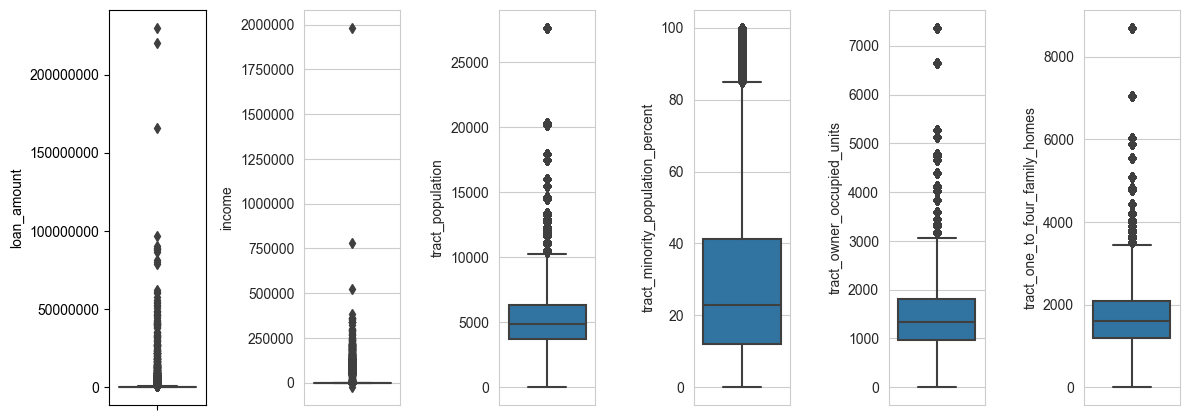

In [23]:
outl_cols = ['loan_amount', 'income', 'tract_population', 'tract_minority_population_percent', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes']
number_of_columns=len(outl_cols)
number_of_rows = len(outl_cols)-1/number_of_columns
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(outl_cols)):
    plt.subplot(round(number_of_rows + 1),number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(y = df[outl_cols[i]],orient='h')
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()

We can see from the box plot above that almost all the features shows outliers present in the dataset. Let's now check the linearity of the variables by plotting distribution graph and look for skewness of features using Kernel density estimate (kde)

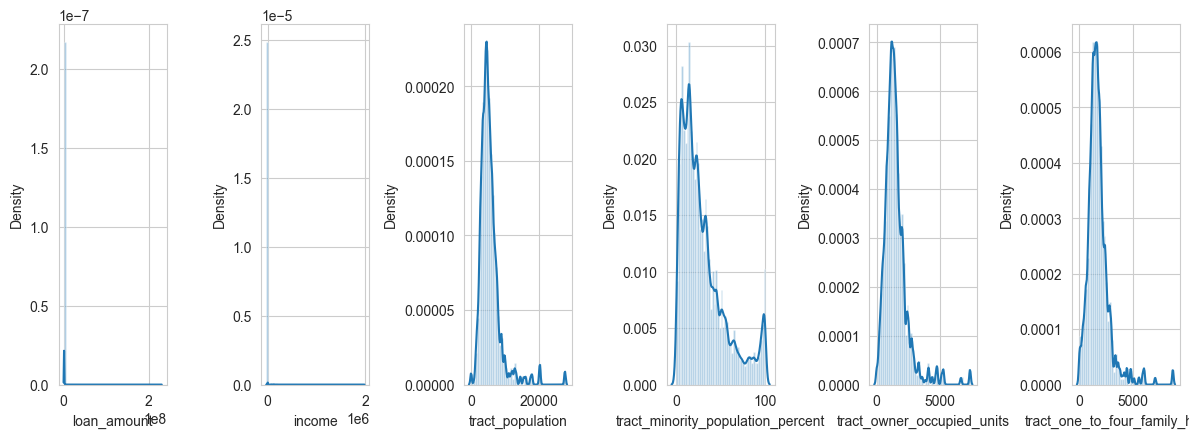

In [24]:
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(outl_cols)):
    plt.subplot(round(number_of_rows + 1),number_of_columns,i+1)
    sns.distplot(df[outl_cols[i]],kde=True) 
    plt.tight_layout()

All the predictor variables depicted in kde graph above are right skewed/positively skewed

<a id="47"></a>
#### g. Explore Additional Predictor Variables

Let's now explore the relationship between target variable 'action_taken' and categorical features 'derived_loan_product_type', 'co-applicant_age_above_62', 'total_units', 'applicant_age_above_62', 'derived_dwelling_category', 'co-applicant_age', 'conforming_loan_limit', 'applicant_age' using count plots. Basically, we will look for categorical features that change significantly with the target classes

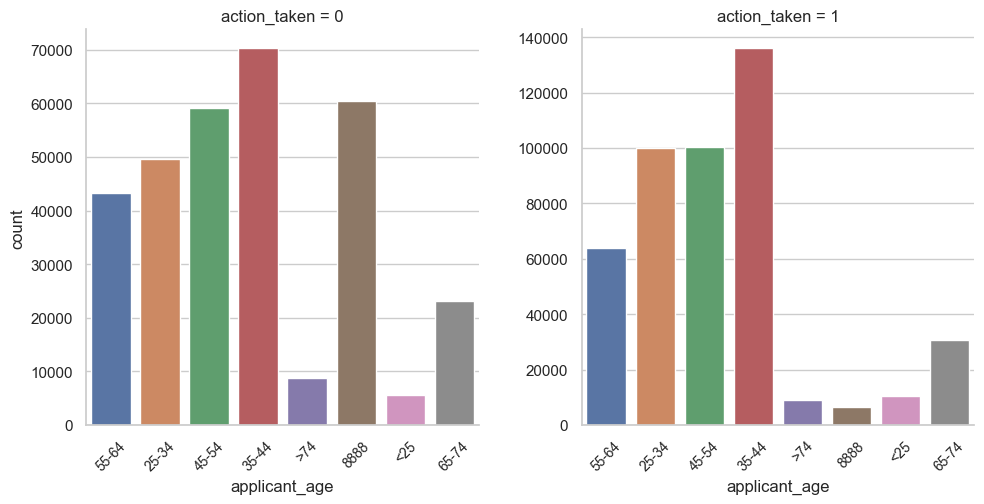

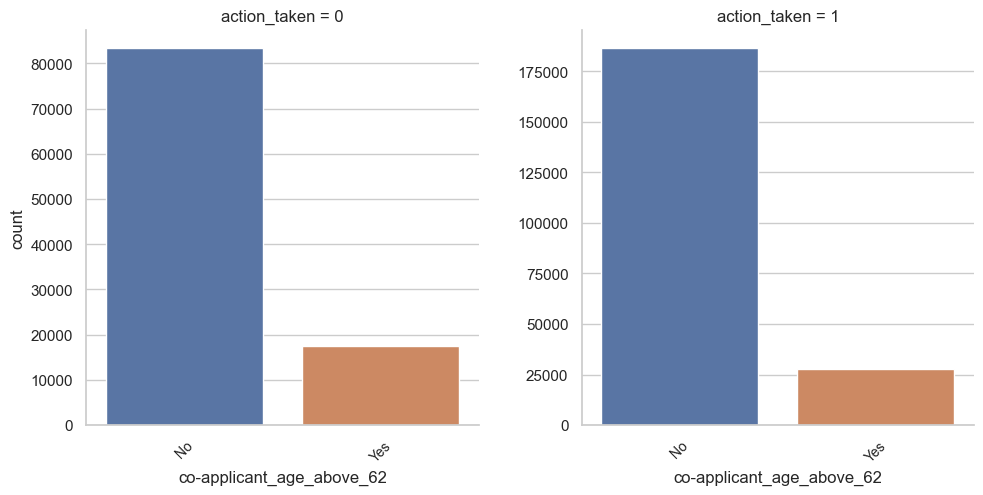

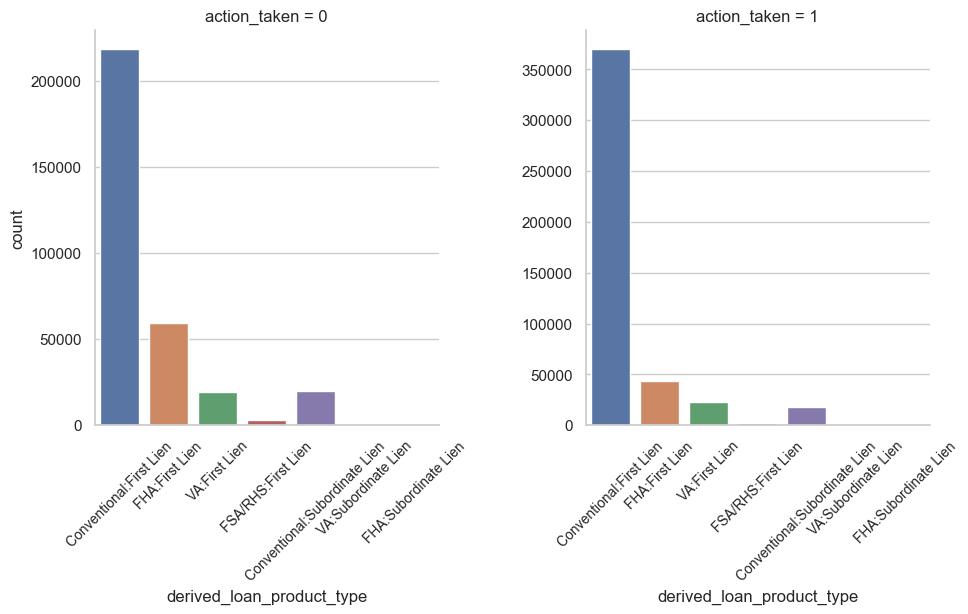

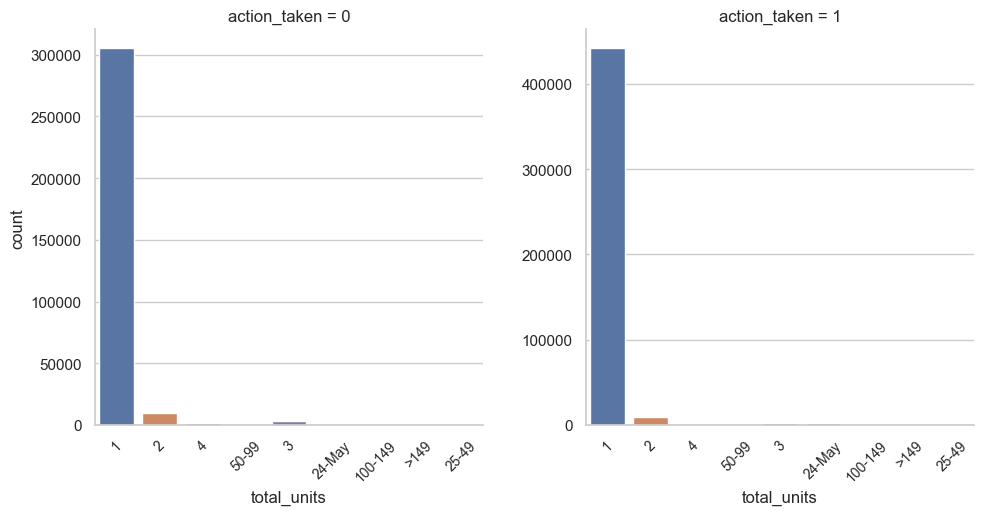

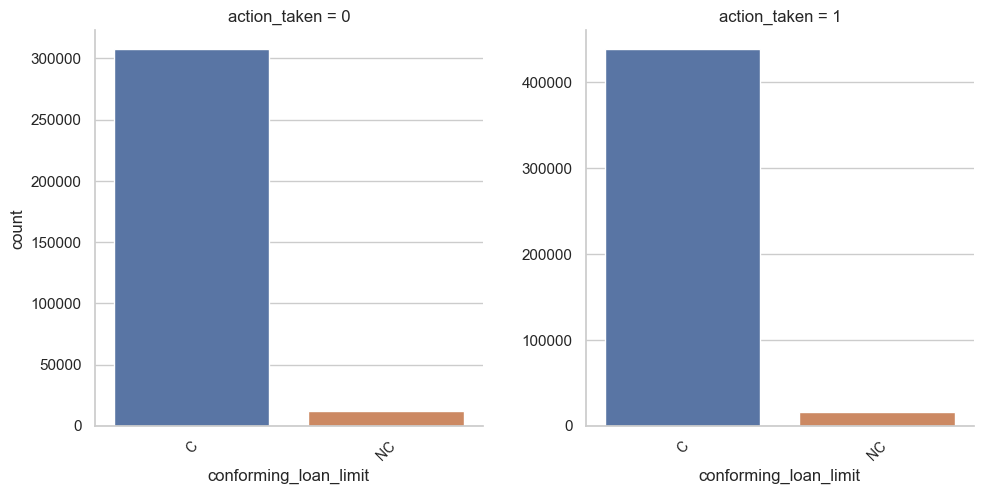

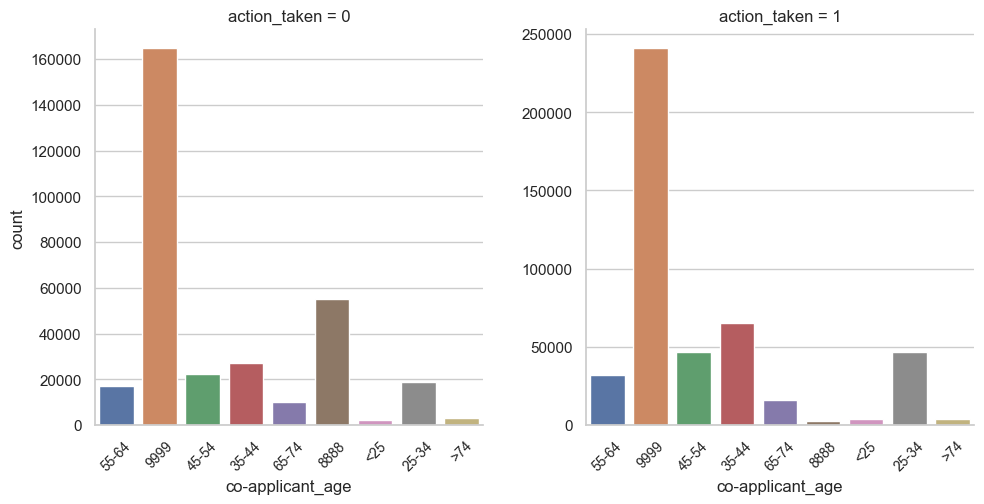

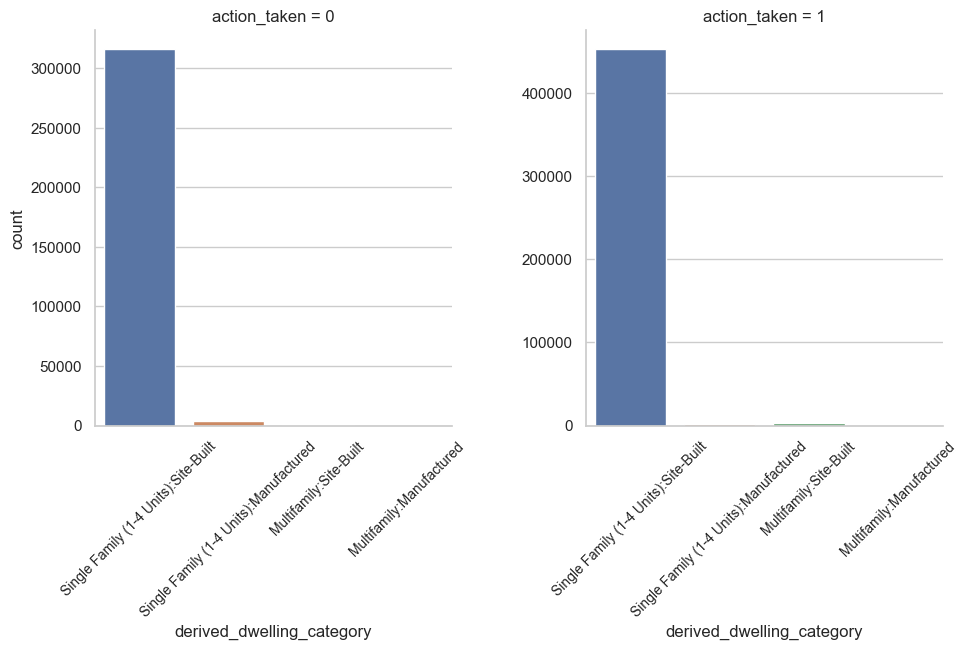

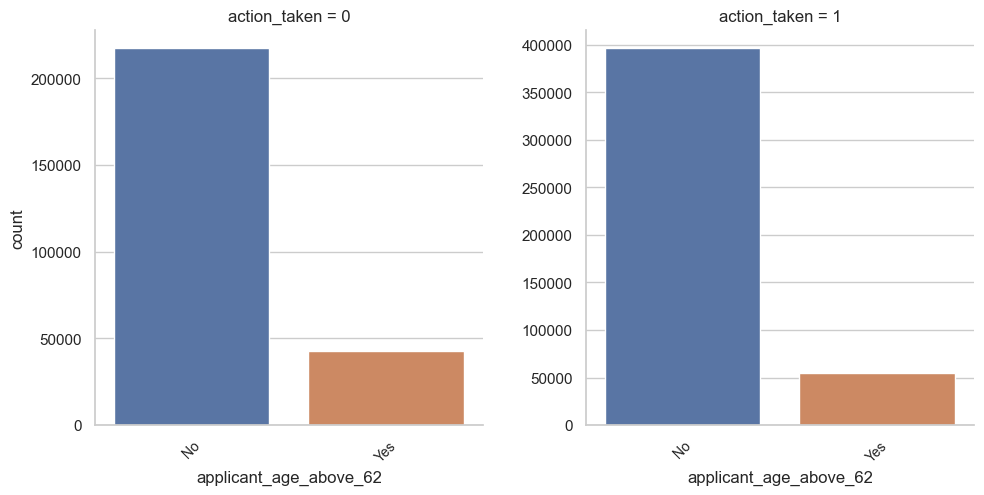

In [25]:
cat_features_remaining = [e for e in cat_features_remaining if e not in ('lei', 'state_code')]
sns.set_theme(style="whitegrid")
for col in cat_features_remaining:
    g = sns.catplot(x = col, kind='count', col = 'action_taken', data=df, sharey=False)
    g.set_xticklabels(rotation=45, size = 10)

Based on the above plots:
- we cannot observe significant difference in how the target feature 'action_taken' is distributed among features 'derived_loan_product_type', 'co-applicant_age_above_62', 'total_units', 'applicant_age_above_62', 'derived_dwelling_category', 'co-applicant_age', 'conforming_loan_limit' and 'applicant age'
- We will run several checks once again to determine each feature importance later in the feature engineering section

<a id="5"></a>
### 5. Data Transformation and Preprocessing

<a id="51"></a>
#### a. Data Transformation

<a id="511"></a>
##### i. Changing feature values to an integer and creating flags for 'Exempt'

We saw previously in the summary statistics section thet the feature 'debt_to_income_ratio' had values which were integers like 36, 37 as well as text values mentioned as '30%-<36%', '20%-<30%'. We will define a function to convert the text values such as '<20%', '20%-<30%', '30%-<36%', '50%-60%' and '>60%' into their numeric counterparts by taking a middle number for each range value i.e. we will recode:
- '<20%' as 10
- '20%-<30%' as 25
- '30%-<36%' as 33
- '50%-60%' as 55 and 
- '>60%' as 80

After recoding, we will create flag for 'Exempt' values i.e. rows where we had 'Exempt' mentioned, we will create a flag or new feature and assign it a value 1 if row had 'Exempt' or 0 otherwise. We will use this same flag function for the features that had 'Exempt' hard coded as data values. We previously created a list of features `cat_features_with_Exempt` containing 'Exempt' values. In reality, all these features were actually numeric but with the presence of 'Exempt' being hard coded they were read as 'categorical' earlier in the project. In total we had 14 features in list `cat_features_with_Exempt', hence we will create 14 new flag features.

Lastly, we will replace the 'Exempt' value from all the 14 features with None and later in the model development section, we will make use of `sklearn SimpleImputer` class to take care of missing values.

We will make use of the same function on the unseen data as well before making predictions on unseen data. The golden rule of machine learning is that test data cannot influence the training phase in any way because when test data influences our training and the test data is no longer unseen data, then the test score will be too optimistic. The same rule apply for validation data as well. Since we are just recoding the values in the dataset since we know the possible values and hence it is reasonable to 'violate the golden rule' and apply the recoding on the entire dataset before splitting it in train and test dataset. 

Reference: https://bait509-ubc.github.io/BAIT509/lectures/lecture2.html#the-golden-rule

In [26]:
def transform_debt_to_income_ratio(x):
    value = x
    if x=='<20%':
        value = 10
    elif x=='20%-<30%':   
        value = 25
    elif x=='30%-<36%':
        value = 33   
    elif x=='50%-60%': 
        value = 55
    elif x=='>60%': 
        value = 80
    else:
        try:
            x_int = int(x)
            value = x_int
        except:
            pass   
    return value

## function to create flag or new feature for features which has 'Exempt' values
def flag(x):
    value = x
    if x=='Exempt':
        value = 1
    else:
        value = 0
    return value

Let's apply the function `transform_debt_to_income_ratio` on debt_to_income_ratio feature

In [27]:
df['debt_to_income_ratio'] = df['debt_to_income_ratio'].apply(transform_debt_to_income_ratio)

Next, we create new flags or features for Exempt values

In [28]:
for feature in cat_features_with_Exempt:
    df['flag_'+str(feature)] = df[feature].apply(flag)

Let's change the data type of features with Exempt values from 'Object' to 'Float'

In [29]:
for feature in cat_features_with_Exempt:
    df[feature] = pd.to_numeric(df[feature],errors = 'coerce')

Lastly, we replace all 'Exempt' values with None

In [30]:
df = df.replace({'Exempt': None})

Let's check if the feature 'debt_to_income_ratio' was transformed correctly.

In [31]:
df['debt_to_income_ratio'].value_counts()

25.0    118333
33.0     85452
10.0     52574
55.0     21354
44.0     16761
42.0     16161
41.0     15367
43.0     15171
39.0     15150
40.0     15102
36.0     14887
37.0     14868
38.0     14833
80.0     14694
49.0     11000
45.0     10935
48.0      9699
46.0      9653
47.0      9316
Name: debt_to_income_ratio, dtype: int64

As can be seen above, we successfully transformed text values such as '<20%', '20%-<30%', '30%-<36%', '50%-60%' and '>60%' into their numeric counterparts. In addition, we can also see that we no longer have 'Exempt' values in debt_to_income_ratio feature. Now, we will also check newly created flag features to see if count of 1 for all 14 new features matches with the 'Exempt' count we previously found in summary statistics section

In [32]:
flag_features = [col for col in df if col.startswith('flag')]
for col in flag_features:
    print('{} has {} Exempt flags'.format(col, df[col].value_counts()[1]))
    print('----------------------------------')

flag_loan_to_value_ratio has 37440 Exempt flags
----------------------------------
flag_interest_rate has 37440 Exempt flags
----------------------------------
flag_rate_spread has 38824 Exempt flags
----------------------------------
flag_total_loan_costs has 37466 Exempt flags
----------------------------------
flag_total_points_and_fees has 37466 Exempt flags
----------------------------------
flag_origination_charges has 37466 Exempt flags
----------------------------------
flag_discount_points has 37466 Exempt flags
----------------------------------
flag_lender_credits has 37466 Exempt flags
----------------------------------
flag_loan_term has 37440 Exempt flags
----------------------------------
flag_prepayment_penalty_term has 37444 Exempt flags
----------------------------------
flag_intro_rate_period has 37437 Exempt flags
----------------------------------
flag_property_value has 37460 Exempt flags
----------------------------------
flag_multifamily_affordable_units has 376

As expected, the exempt flag count matches with the 'Exempt' count we previosuly found in summary statistics section

<a id="512"></a>
##### ii. Creating calculated field 'calculated_loan_to_value_ratio'

In the [Check for Missing Values](#d-check-for-missing-values) section of EDA, we observed that feature 'loan_to_value_ratio' had 252242 missing values. The feature 'loan_to_value_ratio' can actually be calculated by dividing feature 'loan_amount' with feature 'property_value'. Now, we will create a function to create this calculated field

In [33]:
df['calculated_loan_to_value_ratio'] = round((df['loan_amount']/df['property_value'])*100,3)

In [34]:
print(df['calculated_loan_to_value_ratio'].describe(), df['calculated_loan_to_value_ratio'].value_counts())

count    583637.000000
mean         73.875164
std          28.839774
min           0.074000
25%          63.636000
50%          77.778000
75%          90.164000
max        5100.000000
Name: calculated_loan_to_value_ratio, dtype: float64 100.000    50356
77.778      6924
71.429      5479
60.000      5251
81.818      4791
           ...  
56.009         1
5.164          1
11.273         1
41.511         1
7.824          1
Name: calculated_loan_to_value_ratio, Length: 10064, dtype: int64


We now have 583,637 complete values for feature 'calculated_loan_to_value_ratio' compared to 525,601 complete values for feature 'loan_to_value_ratio'

<a id="513"></a>
##### iii. Fill blanks with zero for 'discount_points', 'lender_credits', 'aus-2', 'aus-3', 'aus-4', 'aus-5'

In the [Check for Missing Values](#d-check-for-missing-values) section of EDA, it was found under the filing instructions manual that for features 'discount_points' and 'lender_credits' that if no discount_points or lender_credits were provided, then these feature values will be blank. Hence, we can safely transform the blank values to 0.

In addition, it was also observed that features 'aus-2', 'aus-3', 'aus-4' and 'aus-5' though looks to have missing values in them, however, after reading through the data field explanation, it was assumed that the feature 'aus' i.e. automated underwriting system that the financial institution used to evaluate the loan application was broken down into five separate features since a financial institution might have used more than one automated underwriting system to evaluate a loan application. Hence, we would proceed with filling blank values in features 'aus-2', 'aus-3', 'aus-4' and 'aus-5' with 0

In [35]:
fill_zero_features = ['discount_points', 'lender_credits', 'aus-2', 'aus-3', 'aus-4', 'aus-5']
for col in fill_zero_features:
    df[col].fillna(value = 0, inplace = True)

In [36]:
df.isnull().sum()

activity_year                                    0
lei                                              0
derived_msa-md                                   0
state_code                                       0
county_code                                   2900
census_tract                                  3117
conforming_loan_limit                         3083
derived_loan_product_type                        0
derived_dwelling_category                        0
action_taken                                     0
purchaser_type                                   0
preapproval                                      0
loan_type                                        0
loan_purpose                                     0
lien_status                                      0
reverse_mortgage                                 0
open-end_line_of_credit                          0
business_or_commercial_purpose                   0
loan_amount                                      0
loan_to_value_ratio            

As can be seen from the output above that blank values were successfully converted to 0 values for features 'discount_points', 'lender_credits', 'aus-2', 'aus-3', 'aus-4', 'aus-5' and hence we have no more missing values for these features.

<a id="514"></a>
##### iv. Change values from '24-May' to '5-24' for feature 'total_units'

In the [Summary Statistics](#c-summary-statistics) section of EDA, it was found upon closely inspecting unique values for feature 'total_units', that one of the value label '5-24' got transformed into a date format '24-May'. Hence, we now transform '24-May' values to '5-24'

In [37]:
def convert_date(x):
    value = x
    if x=='24-May':
        value = '5-24'
    return value

In [38]:
df['total_units'] = df['total_units'].apply(convert_date)

In [39]:
df['total_units'].value_counts()

1          746925
2           19070
3            5656
4            3109
5-24         2279
25-49         388
50-99         208
>149          109
100-149        99
Name: total_units, dtype: int64

As can be seen from the output above that we successfully converted date value '24-May' to the correct value '5-24'.

<a id="52"></a>
#### b. Data Preprocessing

<a id="521"></a>
##### i. Removing Denial Features

Removing 'denial_reason-1', 'denial_reason-2', 'denial_reason-3', 'denial_reason-4' as per the project instructions

In [40]:
df.shape # let's print the shape before dropping above discussed 4 features (777843, 83)

(777843, 83)

In [41]:
denial_features = [col for col in df if col.startswith('denial')]
df.drop(denial_features, axis = 1, inplace = True)

In [42]:
df.shape # let's print the shape after dropping above discussed 4 features. Expected Shape: (777843, 79)

(777843, 79)

<a id="522"></a>
##### ii. Removing Features with just one unique value

In [43]:
one_unique_features = list(df.columns[df.nunique() <= 1])
df.drop(one_unique_features, axis = 1, inplace = True) ## Features 'activity_year' and 'state_code' has just one unique value

In [44]:
df.shape # let's print the shape after one unique features. Expected Shape: (777843, 77)

(777843, 77)

<a id="523"></a>
##### iii. Removing Features which are identifiers

In [45]:
identifiers = ['lei', 'derived_msa-md', 'county_code', 'census_tract'] ## these features are more like identifiers to identify financial institution, counties and census tracts
df.drop(identifiers, axis = 1, inplace = True)

In [46]:
df.shape # let's print the shape after dropping identifier features. Expected Shape: (777843, 73)

(777843, 73)

<a id="6"></a>
### 6. Feature Engineering

<a id="61"></a>
#### a. Exploratory Feature Reduction

Let's use Principle Component Analysis (PCA), a feature reduction technique to see how many features can be used for data modeling. In other words, PCA is a technique to obtain important features from a large set of features which explains the most of the variability in the data. Let's start implementing PCA by first removing response variable from the dataset.

In [48]:
df_tmp = df.drop(['action_taken'], axis = 1)
df_tmp.shape

(777843, 72)

In [49]:
pca_num_features = df_tmp.dtypes[df_tmp.dtypes != "object"].index
print("Number of Numerical features: ", len(pca_num_features))

pca_cat_features = df_tmp.dtypes[df_tmp.dtypes == "object"].index
print("Number of Categorical features: ", len(pca_cat_features))

Number of Numerical features:  64
Number of Categorical features:  8


In [50]:
for col in pca_num_features:
    df_tmp[col].fillna(df_tmp[col].median(), inplace = True)

In [51]:
for col in pca_cat_features:
    df_tmp[col].fillna(value = 'Unknown', inplace = True)

Let's use One-hot Encoding, a feature encoding strategy, first to convert our categorical features into a numerical feature

In [52]:
df_tmp = pd.get_dummies(df_tmp, columns= pca_cat_features, drop_first = True)

In [53]:
#convert it to numpy arrays
X=df_tmp.values

#Scaling the values
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

#grab number of components from shape output
pca = PCA(n_components = 72)
pca.fit_transform(X)

array([[-1.31458617e+00, -4.03833283e+00,  1.66113896e+00, ...,
         6.61402143e-04,  1.23205795e-03,  6.25665811e-04],
       [ 2.35695824e+01,  6.49383367e-01, -8.16230981e-01, ...,
        -2.94463686e-03,  1.06497691e-03,  6.87466935e-03],
       [-1.09684456e+00,  7.93388172e-02, -4.98836458e-01, ...,
         1.32602799e-04, -4.47039664e-04, -7.91771149e-03],
       ...,
       [-1.17284255e+00, -8.12361052e-01,  7.40681479e-01, ...,
        -7.35098225e-04,  1.79089768e-03,  7.90603545e-04],
       [-1.18679640e+00,  6.38947245e-01,  5.11956854e-01, ...,
         1.37765290e-03, -2.94107612e-03, -4.72248956e-03],
       [-1.28201924e+00, -5.86843116e-01,  3.20406227e-01, ...,
         1.66912771e-03,  5.23394043e-04, -1.60766337e-04]])

In [54]:
var= pca.explained_variance_ratio_

Let's build a scree plot i.e. a line plot that shows the eigenvalues for each individual principal component. Scree plot helps us to access components or factors which explains the most of variability in the data. It represents values in descending order.

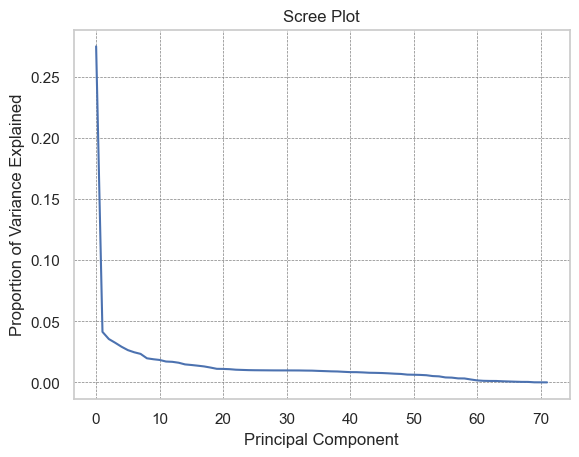

In [55]:
plt.grid(which='major', linestyle='--', linewidth='0.5', color='grey')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.plot(var)

The above scree plot indicates that approx. 2 principal components were able to capture most of the information. 

In [56]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1)

[27.49 31.63 35.18 38.42 41.34 43.98 46.45 48.78 50.75 52.65 54.49 56.2
 57.88 59.49 60.96 62.38 63.75 65.06 66.28 67.39 68.49 69.57 70.61 71.63
 72.63 73.63 74.62 75.61 76.59 77.57 78.55 79.53 80.51 81.48 82.44 83.38
 84.3  85.21 86.1  86.97 87.81 88.65 89.47 90.26 91.04 91.81 92.55 93.26
 93.95 94.59 95.22 95.83 96.42 96.94 97.43 97.84 98.23 98.56 98.88 99.12
 99.28 99.41 99.53 99.65 99.74 99.82 99.88 99.92 99.96 99.97 99.98 99.98]


The above cumulative variance can be read as follows:
It shows that first principal component explains 27.49% variance. The first and second component cumulatively explains 31.63% variance or we can say that second principal component alone explains 4.14% variance. First, second and third component cumulatively explains 35.18% variance and so on. Let's now plot cumulative variance

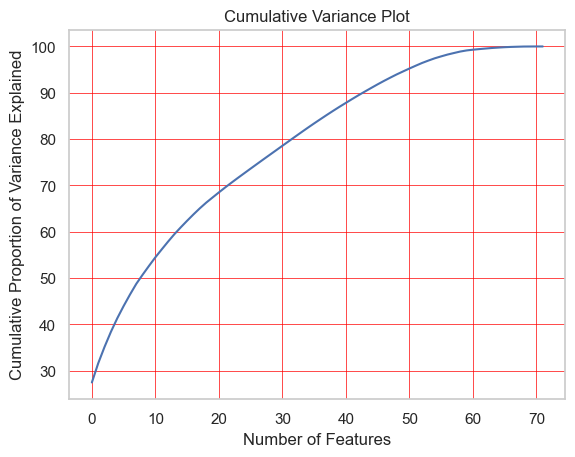

In [57]:
# cumulative scree plot
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.title('Cumulative Variance Plot')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.plot(var1)

The above plot shows that ~ 50 features result in variance close to ~ 95%. The PCA analysis gives us a ballpark estimate of the number of features that explains majority of the variation in the dataset and hence can be used for data modeling. However, let's use Gradient Boosting Machine (GBM) in the later [Feature Selection](#) section to automatically calculate feature importance

<a id="62"></a>
#### b. Feature Selection

I am going to use a pre built `FeatureSelector` class made available by Will Koehrsen on their [GitHub](https://github.com/WillKoehrsen/feature-selector/blob/master/feature_selector/feature_selector.py). This `FeatureSelector` includes the following most common feature selection methods:

- Features with a high percentage of missing values
- Collinear (highly correlated) features
- Features with zero importance in a tree-based model
- Features with low importance
- Features with a single unique value

In [58]:
labels = df['action_taken']
data_fs = df.drop(columns = ['action_taken'])

The `FeatureSelector` class requires a dataset with observations in the rows and features in the columns. Since we are working with a machine learning classification problem so we also pass in training labels.

In [59]:
fs = FeatureSelector(data = data_fs, labels = labels) # Let's inititate the class FeatureSelector()

<a id="621"></a>
##### i. Find Features with high percentage of missing values

The first feature selection method is straightforward: find any columns with a missing fraction greater than a specified threshold. For this example I have taken a threshold of 0.85 which corresponds to finding features with more than 85% missing values. Note: This method does not one-hot encode the features first.


In [60]:
fs.identify_missing(missing_threshold=0.85)

4 features with greater than 0.85 missing values.



In [61]:
missing_features = fs.ops['missing']
print("Names of these features are:""\n", missing_features)

Names of these features are:
 ['total_points_and_fees', 'prepayment_penalty_term', 'intro_rate_period', 'multifamily_affordable_units']


<a id="622"></a>
##### ii. Find Features with single unique value

The next method is straightforward: find any features that have only a single unique value. (This does not one-hot encode the features).


In [62]:
fs.identify_single_unique()
single_unique = fs.ops['single_unique']
single_unique

0 features with a single unique value.



[]

<a id="623"></a>
##### iii. Find Collinear Features

This method finds pairs of collinear features based on the Pearson correlation coefficient. For each pair above the specified threshold (in terms of absolute value), it identifies one of the variables to be removed. We need to pass in a correlation_threshold.

For each pair, the feature that will be removed is the one that comes last in terms of the column ordering in the dataframe. (This method does not one-hot encode the data beforehand unless one_hot=True. Therefore correlations are only calculated between numeric columns)

In [63]:
fs.identify_collinear(correlation_threshold=0.95, one_hot= True)
correlated_features = fs.ops['collinear']
print('----------------------------------------------------------------------------------------')
print('These features are: \n{}'.format(correlated_features))

29 features with a correlation magnitude greater than 0.95.

----------------------------------------------------------------------------------------
These features are: 
['open-end_line_of_credit', 'business_or_commercial_purpose', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest', 'applicant_credit_score_type', 'co-applicant_credit_score_type', 'submission_of_application', 'initially_payable_to_institution', 'aus-1', 'flag_loan_to_value_ratio', 'flag_interest_rate', 'flag_rate_spread', 'flag_total_loan_costs', 'flag_total_points_and_fees', 'flag_origination_charges', 'flag_discount_points', 'flag_lender_credits', 'flag_loan_term', 'flag_prepayment_penalty_term', 'flag_intro_rate_period', 'flag_property_value', 'flag_multifamily_affordable_units', 'flag_debt_to_income_ratio', 'derived_loan_product_type_Conventional:Subordinate Lien', 'derived_dwellin

Let's now plot all the correlations which were found to be above threshold using correlation heatmap of the correlation values

<AxesSubplot: >

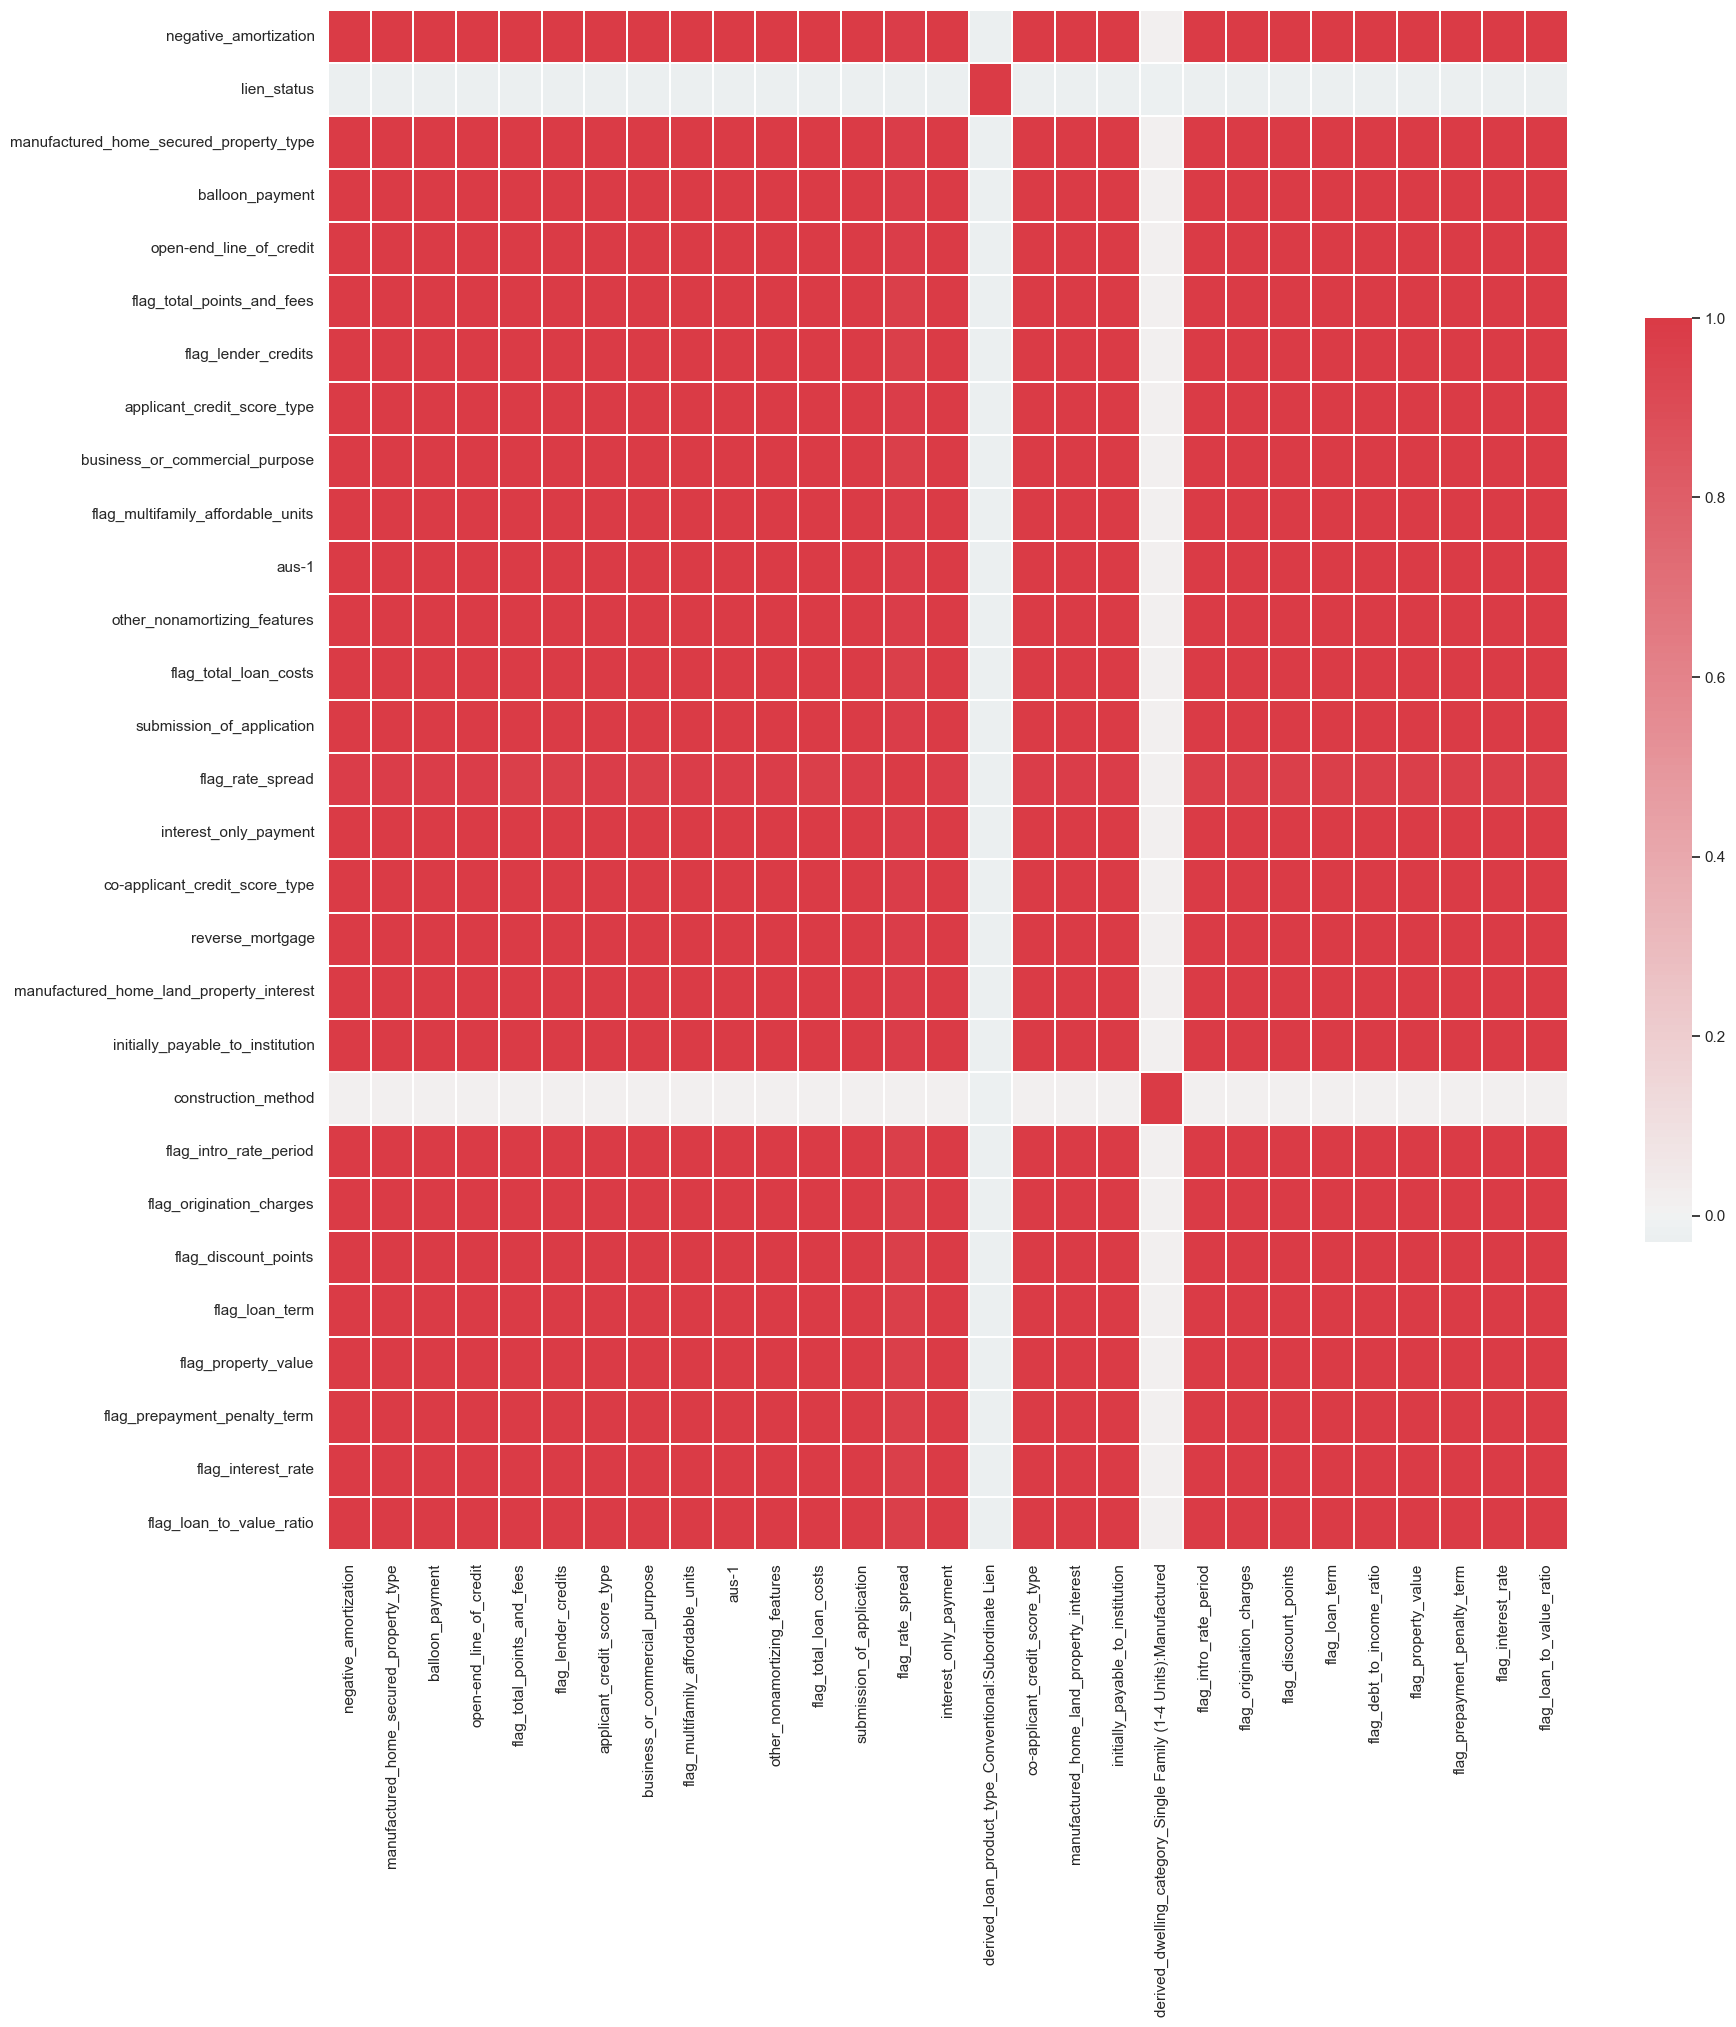

In [64]:
corr_mat_plt = fs.corr_matrix.loc[list(set(fs.record_collinear['corr_feature'])), 
	                                                list(set(fs.record_collinear['drop_feature']))]
f, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_mat_plt, cmap=cmap, center=0,
                    linewidths=.25, cbar_kws={"shrink": 0.6})

The features which will be dropped are on the x-axis in the above heatmap plot

Let's also check which pair of features were found to be correlated with each other and their respective correlation values. The features in `drop_feature` column in below dataframe will be removed and for each of the feature that will be removed, there may be several correlations it has with the `corr_value` above the `correlation_threshold`. 

In [65]:
fs.record_collinear

,drop_feature,corr_feature,corr_value
0,open-end_line_of_credit,reverse_mortgage,0.999860
1,business_or_commercial_purpose,reverse_mortgage,0.998591
2,business_or_commercial_purpose,open-end_line_of_credit,0.998452
3,negative_amortization,reverse_mortgage,0.999582
4,negative_amortization,open-end_line_of_credit,0.999443
5,negative_amortization,business_or_commercial_purpose,0.998172
6,interest_only_payment,reverse_mortgage,0.999582
7,interest_only_payment,open-end_line_of_credit,0.999443
8,interest_only_payment,business_or_commercial_purpose,0.998172
9,interest_only_payment,negative_amortization,1.000000


<a id="624"></a>
##### iv. Find Features with Zero Importance using GBM

In [66]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', n_iterations = 10, early_stopping = True)
print('----------------------------------------------------------------------------------------')
print('These features are: \n{}'.format(fs.ops['zero_importance']))
## this will take about 4 minutes to run depending on the computing power on your machine

(777843,) (777843, 107)
Training Gradient Boosting Model


12 features with zero importance after one-hot encoding.

----------------------------------------------------------------------------------------
These features are: 
['flag_interest_rate', 'flag_origination_charges', 'aus-4', 'derived_dwelling_category_Multifamily:Manufactured', 'derived_loan_product_type_VA:Subordinate Lien', 'derived_loan_product_type_FSA/RHS:First Lien', 'derived_loan_product_type_FHA:Subordinate Lien', 'aus-5', 'flag_loan_term', 'flag_lender_credits', 'flag_discount_points', 'flag_total_points_and_fees']


The above method of feature selection has been designed for machine learning problem. Using Gradient Boosting Machine learning model from the [LightGBM Library](https://lightgbm.readthedocs.io/en/v3.3.2/), we tried to find the features from our dataset which have zero importance. These features were averaged over 10 training runs in order to reduce variance. As we can observe from the above results, 12 features were found to have zero importance and we can remove these features later on without affecting model performance. 

The feature importance plot using plot_feature_importances will show us the plot_n most important features (on a normalized scale where the features sum to 1). It also shows us the cumulative feature importance versus the number of features.

When we plot the feature importances, we can pass in a threshold which identifies the number of features required to reach a specified cumulative feature importance. For example, threshold = 0.95 will tell us the number of features needed to account for 95% of the total importance. Let's now check how many features have a cumulative importance of 95% and also see the top 20 features in order of their importance.

**Note:** The feature imporances from the model are non-deterministic (i.e. they have a little randomness). Hence, the results of running this method can change each time it is run.


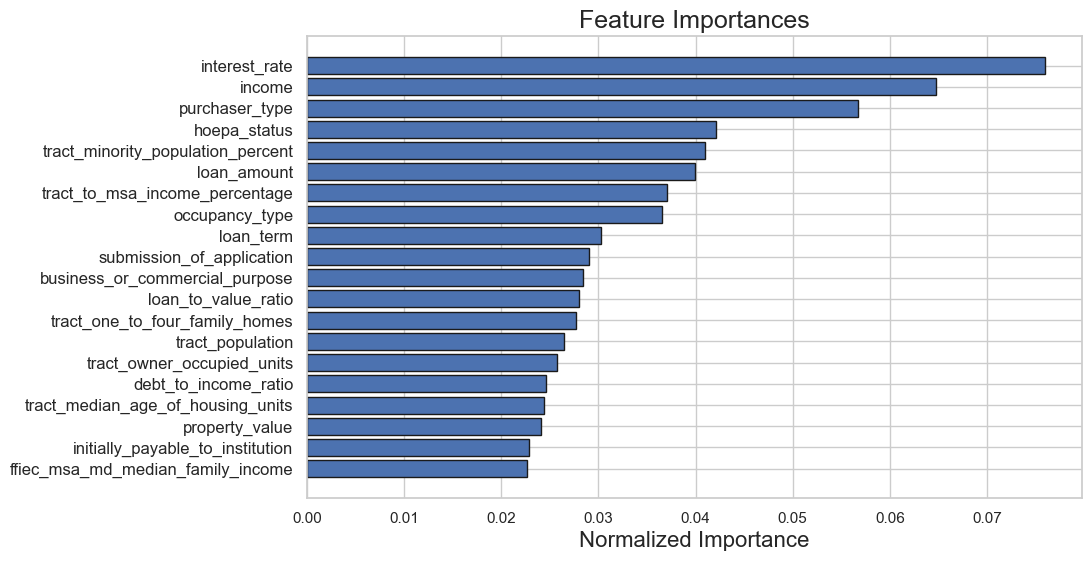

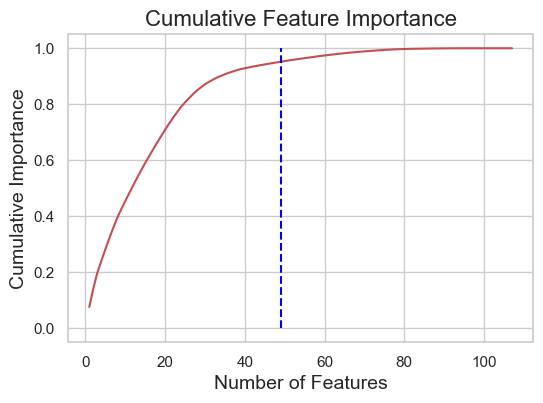

49 features required for 0.95 of cumulative importance


In [67]:
fs.plot_feature_importances(threshold = 0.95, plot_n = 20)

As can be seen from the first plot, the top 20 features have been plotted by their normalized importance. The plot at the bottom shows cumulative importance plotted on y-axis and number of features on x-axis. The vertical dotted line is drawn at the threshold value of cumulative importance we chose above i.e. 95%. We can notice that 49 features are required for 95% of the cumulative importance. It is worth noting here that these results coincide with what we found in PCA analysis above. In the PCA analysis above, we found approx. 50 features resulting in a cumulative variance of 95%.

In [68]:
top_features = list(fs.feature_importances.loc[:49, 'feature'])
print(top_features)

['interest_rate', 'income', 'purchaser_type', 'hoepa_status', 'tract_minority_population_percent', 'loan_amount', 'tract_to_msa_income_percentage', 'occupancy_type', 'loan_term', 'submission_of_application', 'business_or_commercial_purpose', 'loan_to_value_ratio', 'tract_one_to_four_family_homes', 'tract_population', 'tract_owner_occupied_units', 'debt_to_income_ratio', 'tract_median_age_of_housing_units', 'property_value', 'initially_payable_to_institution', 'ffiec_msa_md_median_family_income', 'rate_spread', 'loan_purpose', 'calculated_loan_to_value_ratio', 'origination_charges', 'intro_rate_period', 'total_loan_costs', 'applicant_age_8888', 'aus-1', 'co-applicant_credit_score_type', 'reverse_mortgage', 'total_points_and_fees', 'preapproval', 'applicant_credit_score_type', 'lien_status', 'open-end_line_of_credit', 'flag_rate_spread', 'co-applicant_age_8888', 'total_units_1', 'loan_type', 'total_units_3', 'derived_dwelling_category_Single Family (1-4 Units):Site-Built', 'co-applicant_

<a id="625"></a>
##### v. Find Low Importance Features

This method compiles feature importances from the GBM by finding the lowest importance features not needed to reach a specified cumulative total feature importance. For example, below we passed 0.95, this will find the lowest important features that are not needed to reach 95% of the total feature importance.

**Note**: This method builds on the gradient boosting model features importances and is non-deterministic. Hence, the results of running this method can change each time it is run.

In [69]:
fs.identify_low_importance(cumulative_importance = 0.95)

48 features required for cumulative importance of 0.95 after one hot encoding.
59 features do not contribute to cumulative importance of 0.95.



As you can notice, based on the cumulative importance threshold value of 95%, the gradient boosting machine considers 59 features to be not relevant for model learning purpose.

The low importance features that do not contribute to the specified cumulative importance can be found below:

In [70]:
low_importance_features = fs.ops['low_importance']
print(low_importance_features)

['interest_only_payment', 'aus-2', 'co-applicant_age_35-44', 'co-applicant_age_45-54', 'co-applicant_age_above_62_Yes', 'applicant_age_25-34', 'total_units_2', 'balloon_payment', 'co-applicant_age_55-64', 'applicant_age_above_62_No', 'applicant_age_45-54', 'applicant_age_55-64', 'conforming_loan_limit_C', 'negative_amortization', 'flag_property_value', 'total_units_4', 'total_units_5-24', 'derived_loan_product_type_Conventional:Subordinate Lien', 'co-applicant_age_25-34', 'co-applicant_age_65-74', 'derived_dwelling_category_Multifamily:Site-Built', 'conforming_loan_limit_NC', 'applicant_age_>74', 'construction_method', 'total_units_25-49', 'applicant_age_<25', 'applicant_age_above_62_Yes', 'manufactured_home_land_property_interest', 'co-applicant_age_>74', 'other_nonamortizing_features', 'flag_multifamily_affordable_units', 'lender_credits', 'derived_loan_product_type_VA:First Lien', 'flag_loan_to_value_ratio', 'derived_dwelling_category_Single Family (1-4 Units):Manufactured', 'total_

<a id="626"></a>
##### vi. Removing Features

Once we have identified the features to remove using above five methods in [Feature Selection](#b-feature-selection), we can remove these features by passing in `method = 'all'`. However, before removing these features it's a good practice to check how many and which features will be removed. Let's see this below:

In [71]:
all_to_remove = fs.check_removal()
print(all_to_remove)

Total of 71 features identified for removal
['negative_amortization', 'manufactured_home_secured_property_type', 'derived_loan_product_type_VA:First Lien', 'aus-4', 'conforming_loan_limit_C', 'total_units_50-99', 'balloon_payment', 'derived_dwelling_category_Multifamily:Manufactured', 'open-end_line_of_credit', 'flag_total_points_and_fees', 'co-applicant_age_35-44', 'conforming_loan_limit_NC', 'intro_rate_period', 'lender_credits', 'flag_lender_credits', 'applicant_credit_score_type', 'business_or_commercial_purpose', 'multifamily_affordable_units', 'flag_multifamily_affordable_units', 'applicant_age_45-54', 'derived_dwelling_category_Multifamily:Site-Built', 'co-applicant_age_65-74', 'aus-5', 'co-applicant_age_above_62_Yes', 'derived_loan_product_type_FHA:Subordinate Lien', 'aus-1', 'co-applicant_age_45-54', 'derived_loan_product_type_FSA/RHS:First Lien', 'co-applicant_age_25-34', 'total_units_4', 'aus-3', 'discount_points', 'other_nonamortizing_features', 'flag_total_loan_costs', 'pr

Now, let's drop all these features

In [72]:
data_fs_removed = fs.remove(methods = 'all')

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 71 features.


Now let's see the final set of features that will be used for model development and training

In [73]:
print(list(data_fs_removed.columns))
print(len(data_fs_removed.columns))

['derived_loan_product_type_Conventional:First Lien', 'derived_dwelling_category_Single Family (1-4 Units):Site-Built', 'total_units_1', 'total_units_3', 'applicant_age_35-44', 'applicant_age_65-74', 'applicant_age_8888', 'co-applicant_age_8888', 'co-applicant_age_9999', 'co-applicant_age_above_62_No', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'purchaser_type', 'preapproval', 'loan_type', 'loan_purpose', 'lien_status', 'reverse_mortgage', 'loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread', 'hoepa_status', 'total_loan_costs', 'origination_charges', 'loan_term', 'property_value', 'occupancy_type', 'total_units', 'income', 'debt_to_income_ratio', 'applicant_age', 'co-applicant_age', 'applicant_age_above_62', 'co-applicant_age_above_62', 'tract_population', 'tract_minority_population_percent', 'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes', 'trac

Let's remove the one hot encoding features from the above `data_fs_removed` dataframe i.e. we will remove all the columns which were categorical in nature and were converted to one hot encodings during the process of feature selection. These columns are 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'total_units', 'applicant_age', 'co-applicant_age', 'applicant_age_above_62', 'co-applicant_age_above_62'. The reason we are doing this is because we ran feature selection on the entire training set without separating the test set. In reality, while training the model, we would separate the dataset into two subsets, training and test. The training set will be further divided into two splits during cross validation, training and validation fold, and we don't have any information beforehand whether we would have categories in the test or unseen data that were not in the training data. Usually, if such case arise, an error will occur. In addition, another way to think about this is considering the deployment stage of the model. There is a chance that the data distributions in future might change and we might get new categories in our categorical data features and the model prediction will result in error if there are new categories in the dataset. Hence, we would use the `ColumnTransformer` inside the `Pipelines` in the later section of model development to handle the categorical features.

However, it's worth mentioning here that of all the categories of the categorical features, only 15 were found to be important features by the `FeatureSelector` class

In [74]:
data_fs_removed = data_fs_removed.drop(columns = fs.one_hot_features, errors = 'ignore')
data_fs_removed.shape

(777843, 34)

Let's append our target variable column to final_columns list

In [75]:
final_columns = list(data_fs_removed.columns)
final_columns.append("action_taken")

In [76]:
print('Original Number of Features', data_fs.shape[1])
print('Final Number of Features: ', len(final_columns)-1) # removed 1 for target variable

Original Number of Features 72
Final Number of Features:  34


<a id="7"></a>
### 7. Model Development, Evaluation and Prediction
<a id="71"></a>
#### a. Building Baseline Models with default params

In [77]:
final_data = df[final_columns]
final_data.shape

(777843, 35)

In [78]:
# Separate features and labels
y = final_data['action_taken']
X = final_data.drop(columns =['action_taken'])

We could train a model using all the data we have; however it is a common practice in supervised machine learning to split into two subsets; a larger set with which to train the model, and a smaller holdout data set (also called test set) to provide an unbiased evaluation of a final model fit on the training data set.

Next we do the train-test split and hold out the test set until we decide our final model

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 544490 rows
Test Set: 233353 rows


In [80]:
print(f'X_train shape is:{X_train.shape} \nX_test shape is:{X_test.shape}\ny_train shape is:{y_train.shape}\ny_test shape is:{y_test.shape}')

X_train shape is:(544490, 34) 
X_test shape is:(233353, 34)
y_train shape is:(544490,)
y_test shape is:(233353,)


Next, we normalize the numeric features using `StandardScaler()` to transform our feature data such that its distribution will have a mean value 0 and standard deviation of 1. Normalizing is an important step in machine learning as it brings all the features on the same scale and thus prevents features with large values from producing coefficients that disproportionately affect the predictions. In addition to scaling transformation, we also need to apply one hot encoding to our categorical features to convert categories into numbers since scikit-learn only accepts numeric data as input. We will make use of `ColumnTransformer` by defining the separate preprocessing pipelines, each for numeric and categorical features. 

We will then wrap the column transformer in another pipeline containing our regressor using the `Pipeline` utility available in sklearn and finally use this pipeline inside `cross_validate`

In [81]:
numeric_features = X_train.select_dtypes('number').columns
print("Number of Numerical features: ", len(numeric_features))
categorical_features = X_train.select_dtypes('object').columns
print("Number of Categorical features: ", len(categorical_features))

Number of Numerical features:  26
Number of Categorical features:  8


In [82]:
numeric_transformer = Pipeline(
    steps = [("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps = [("imputer", SimpleImputer(strategy="constant", fill_value="others")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

col_transformer = ColumnTransformer(
    transformers = [
        ("numeric", numeric_transformer, numeric_features), 
        ("categorical", categorical_transformer, categorical_features)
]
)

#### Train Baseline Models with Default Params

Now we start training baseline model using default hyperparameters. We will use cross validation process in model training. If we were to fit the model with the training set while evaluated with the test set, we obtained only a single sample point of evaluation with one test set. How can we be sure it is an accurate evaluation, rather than a value too low or too high by chance? If we have two models, and found that one model is better than another based on the evaluation, how can we know this is also not by chance?

Hence, we make use of cross validation to evaluate each model multiple times with different dataset and take the average score for our decision to choose the final model candidate for evaluation on holdout dataset or test dataset. __Cross validation__ uses k-fold to resample the same dataset multiple times and pretend they are different. With cross validation, as we are evaluating the model, or hyperparameter, the model has to be trained from scratch, each time, without reusing the training result from previous attempts.

**Note:** The Analogy or Similarity based algorithms k-NN as well as SVM with RBF kernel kept running endlessly and never completed execution in the below cross validation training approach and hence these similarity based algorithms were dropped from list of potential model candidates. In case you have better computation power, it is worth trying these similarity based algorithms, however in general the tree based methods outperforms the similarity based methods in terms of computing time and accuracy

In [83]:
pipeline = []
pipeline.append(("Naive Bayes", Pipeline([("preprocessor", col_transformer), ('GNB', GaussianNB())])))
pipeline.append(("Logistic Regression", Pipeline([("preprocessor", col_transformer), ("LR", LogisticRegression(random_state = 123))])))
pipeline.append(("Random Forest", Pipeline([("preprocessor", col_transformer), ('RF', RandomForestClassifier(random_state = 123))])))
pipeline.append(("Gradient Boosting", Pipeline([("preprocessor", col_transformer), ('GBM', GradientBoostingClassifier(random_state = 123))])))
pipeline.append(("XG Boost", Pipeline([("preprocessor", col_transformer), ('xgb', xgb.XGBClassifier(objective = "binary:logistic", random_state = 123 ))])))
#pipeline.append(("SVM", Pipeline([("preprocessor", col_transformer), ('SVC', SVC(random_state = 123))])))

Let's define the scoring criteria by selecting:
- __Root Mean Square Error (RMSE):__ The square root of the mean of the squared difference between predicted and actual values. This yields an absolute metric in the same unit as the label (in this case, Electricity Consumption in KWH). The smaller the value, the better the model is (i.e. in a simplistic sense, it represents the average electricity consumption by which the predictions are wrong!)

- __Coefficient of Determination (usually known as R-squared or R2):__ Higher the value of this metric, the better the fit of the model is. This metric represents how much of the variance between predicted and actual label values the model is able to explain. The R-squared metric might not be considered to be a good metric in our case because R-square value increases artificially as the number of features increases. Hence, we will set RMSE to be the main scoring criteria later in the hyperparameter tuning section

You may use other metrics for evaluation regression models. Refer this [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

In [84]:
names = []
scoring = [
    "accuracy",
    "recall",
    "precision",
    "roc_auc"
]  # scoring can be a string, a list, or a dictionary

results_dict = {
    "Model": [],
    "mean_train_accuracy": [],
    "mean_valid_accuracy": [],
    "mean_train_roc_auc": [],
    "mean_valid_roc_auc": []
}

In [85]:
from lightgbm import train
for name, model in pipeline:
    t = time.time()
    print(name)
    kfold = KFold(n_splits = 5, random_state = 1, shuffle = True)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring = scoring, return_train_score = True, n_jobs = -1)
    sec = round(time.time() - t)
    print(
        f"Model {name} took ({round(sec / 60, 2)} min or {round(sec / 3600, 2)} hours)"
    )
    results_dict['Model'].append(name)
    results_dict['mean_train_accuracy'].append(np.mean(cv_results['train_accuracy']))
    results_dict['mean_valid_accuracy'].append(np.mean(cv_results['test_accuracy']))
    results_dict['mean_train_roc_auc'].append(np.mean(cv_results['train_roc_auc']))
    results_dict['mean_valid_roc_auc'].append(np.mean(cv_results['test_roc_auc']))

results_df = pd.DataFrame(results_dict)
results_df

Naive Bayes
Model Naive Bayes took (0.48 min or 0.01 hours)
Logistic Regression
Model Logistic Regression took (0.6 min or 0.01 hours)
Random Forest
Model Random Forest took (4.5 min or 0.07 hours)
Gradient Boosting
Model Gradient Boosting took (9.17 min or 0.15 hours)
XG Boost
Model XG Boost took (5.58 min or 0.09 hours)


,Model,mean_train_accuracy,mean_valid_accuracy,mean_train_roc_auc,mean_valid_roc_auc
0,Naive Bayes,0.876163,0.875764,0.904256,0.904180
1,Logistic Regression,0.940233,0.940190,0.964163,0.964092
2,Random Forest,0.999986,0.997442,1.000000,0.999910
3,Gradient Boosting,0.995420,0.995350,0.999665,0.999654
4,XG Boost,0.998970,0.997686,0.999993,0.999961


In [86]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

#Credits: https://github.com/UBC-CS/cpsc330/blob/master/lectures/03_ml-fundamentals.ipynb

In [87]:
results = {}
for name, model in pipeline:
    kfold = KFold(n_splits = 5, random_state = 1, shuffle = True)
    results[name] = mean_std_cross_val_scores(
    model, X_train, y_train, cv = kfold, scoring = scoring, return_train_score=True, n_jobs = -1
)
pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision,test_roc_auc,train_roc_auc
Naive Bayes,7.916 (+/- 0.293),2.510 (+/- 0.036),0.876 (+/- 0.009),0.876 (+/- 0.009),0.892 (+/- 0.024),0.892 (+/- 0.023),0.897 (+/- 0.017),0.897 (+/- 0.017),0.904 (+/- 0.003),0.904 (+/- 0.003)
Logistic Regression,20.518 (+/- 1.175),1.617 (+/- 0.057),0.940 (+/- 0.001),0.940 (+/- 0.000),0.977 (+/- 0.001),0.977 (+/- 0.000),0.925 (+/- 0.001),0.925 (+/- 0.000),0.964 (+/- 0.001),0.964 (+/- 0.000)
Random Forest,208.783 (+/- 3.400),6.335 (+/- 0.023),0.997 (+/- 0.000),1.000 (+/- 0.000),0.998 (+/- 0.000),1.000 (+/- 0.000),0.998 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
Gradient Boosting,528.474 (+/- 2.104),2.843 (+/- 0.082),0.995 (+/- 0.000),0.995 (+/- 0.000),0.995 (+/- 0.001),0.995 (+/- 0.000),0.997 (+/- 0.000),0.997 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
XG Boost,308.293 (+/- 3.917),3.736 (+/- 0.055),0.998 (+/- 0.000),0.999 (+/- 0.000),0.998 (+/- 0.000),0.999 (+/- 0.000),0.998 (+/- 0.000),0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)


Above, we evaluated each of the models multiple times with different dataset using cross validation process. From the dataframe and box plots above, we can see that the baseline models more or less perform similar. Let's re-run cross validation after tuning the model hyperparameters

<a id="72"></a>
#### b. Hyperparameter Tuning & Model Comparison

In [88]:
pipeline = []
pipeline.append(("Naive Bayes", Pipeline([("preprocessor", col_transformer), ('GNB', GaussianNB())])))
pipeline.append(("Logistic Regression", Pipeline([("preprocessor", col_transformer), ("LR", LogisticRegression(random_state = 123))])))
pipeline.append(("Random Forest", Pipeline([("preprocessor", col_transformer), ('RF', RandomForestClassifier(random_state = 123))])))
#pipeline.append(("Gradient Boosting", Pipeline([("preprocessor", col_transformer), ('GBM', GradientBoostingClassifier(random_state = 123))])))
pipeline.append(("XG Boost", Pipeline([("preprocessor", col_transformer), ('xgb', xgb.XGBClassifier(objective = "binary:logistic", random_state = 123 ))])))

Next, we define hyperparameters we want to tune for each of the models. Note: We only tuned few hyperparameters; however if you are not constrained by computational resources you may try more hyperparameters or more settings of hyperparameters to tune

In [89]:
# Initialize the hyperparameters for each dictionary

###############################**NOTE**##################################
## Due to constraint over computing power and the project deadline, 
# not all the hyperparameters were tuned. If you have enough computing 
# respurces, you could try to tune more hyperparameters by uncommenting
# the lines in this code block
######################################################################### 

param1 = {}
param1['GNB__var_smoothing'] = np.logspace(0,-9, num=10)

param2 = {}
param2['LR__C'] = 10.0 ** np.arange(-4, 6, 1)

param3 = {}  
param3['RF__n_estimators'] = [25, 50, 100, 200]
param3['RF__max_depth'] = [5, 10, 15] 
# param3['RF__min_samples_split'] = [2, 5, 10]
# param3['min_samples_leaf'] = [5, 10, 15] 

## NOTE: To inject randomness in the Random forest classifier construction we could build tree on a bootstrap sample (i.e., a sample with replacement from training set) 
# param3['bootstrap'] = [True, False] 
## Or, another way to inject randomness if that at each node, we could select random subset of features (this can be tweaked by `max_features` hyperparameter) 
# param3['RF__max_features'] = [1, 'sqrt']
# param3['max_leaf_nodes'] = [5, 10, 15] 

# param4 = {}
# param4['GBM__learning_rate'] = [0.01, 0.05, 0.1, 1.0]
# param4['GBM__n_estimators'] = [50, 100, 150, 200]

param5 = {}
param5['xgb__learning_rate'] = [0.01, 0.1, 1.0]
param5['xgb__n_estimators'] = [25, 50, 100, 200]

In [90]:
params = [param1, param2, param3, param5] ## include param4 in this list if you choose to tune the hyperparameters of GBM model
for param, (name_t, pipe) in zip(params, pipeline):
    print(
        f"Model {name_t} hyperparameter tuning started"
    )
    gridsearch = GridSearchCV(pipe, param_grid = param, cv=5, n_jobs = -1, return_train_score = True)
    gridsearch.fit(X_train, y_train)
    print('-----------------------------------------------')
gridsearch

Model Naive Bayes hyperparameter tuning started
-----------------------------------------------
Model Logistic Regression hyperparameter tuning started
-----------------------------------------------
Model Random Forest hyperparameter tuning started
-----------------------------------------------
Model XG Boost hyperparameter tuning started
-----------------------------------------------


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['purchaser_type', 'preapproval', 'loan_type', 'loan_purpose',
       'lien_status', 'reverse_mortgage', 'loan_amount', 'loan_to_value_ratio',
       'interest_rate', 'rate_...
                                                      max_delta_step=None,
                                                      max_depth=None,
   

In [92]:
gridsearch.best_score_

0.9977042737240354

In [94]:
gridsearch.best_params_

{'xgb__learning_rate': 0.1, 'xgb__n_estimators': 200}

In [95]:
results = pd.DataFrame(gridsearch.cv_results_)
results.T

,0,1,2,3,4,5,6,7,8,9,10,11
mean_fit_time,152.146923,295.477662,585.404743,1123.538001,158.793931,296.738,574.817631,990.081254,154.157396,294.14317,526.704545,732.921385
std_fit_time,0.618959,12.294078,22.130858,30.479059,5.04893,5.846352,22.66157,39.815124,3.373365,12.011616,19.279423,18.897969
mean_score_time,2.016409,2.200953,2.488466,2.875134,2.082388,2.262534,2.840345,2.172754,2.130372,2.214315,2.014596,2.178155
std_score_time,0.03214,0.099587,0.03927,0.155144,0.121626,0.218897,0.284754,0.023771,0.249548,0.065961,0.112722,0.01094
param_xgb__learning_rate,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0
param_xgb__n_estimators,25,50,100,200,25,50,100,200,25,50,100,200
params,"{'xgb__learning_rate': 0.01, 'xgb__n_estimator...","{'xgb__learning_rate': 0.01, 'xgb__n_estimator...","{'xgb__learning_rate': 0.01, 'xgb__n_estimator...","{'xgb__learning_rate': 0.01, 'xgb__n_estimator...","{'xgb__learning_rate': 0.1, 'xgb__n_estimators...","{'xgb__learning_rate': 0.1, 'xgb__n_estimators...","{'xgb__learning_rate': 0.1, 'xgb__n_estimators...","{'xgb__learning_rate': 0.1, 'xgb__n_estimators...","{'xgb__learning_rate': 1.0, 'xgb__n_estimators...","{'xgb__learning_rate': 1.0, 'xgb__n_estimators...","{'xgb__learning_rate': 1.0, 'xgb__n_estimators...","{'xgb__learning_rate': 1.0, 'xgb__n_estimators..."
split0_test_score,0.992397,0.993912,0.995914,0.995969,0.996106,0.996896,0.997484,0.997713,0.997245,0.997337,0.997355,0.99742
split1_test_score,0.992103,0.995693,0.995702,0.995776,0.995849,0.996657,0.997126,0.997567,0.997162,0.997153,0.997098,0.997107
split2_test_score,0.992727,0.995996,0.99618,0.996364,0.996419,0.997392,0.997879,0.998007,0.997631,0.997668,0.997548,0.997695


In [96]:
results = (
    pd.DataFrame(gridsearch.cv_results_).set_index("rank_test_score").sort_index()
)
display(results.T)

rank_test_score,1,2,3,4,5,6,7,8,9,10,11,12
mean_fit_time,990.081254,574.817631,732.921385,294.14317,154.157396,526.704545,296.738,158.793931,1123.538001,585.404743,295.477662,152.146923
std_fit_time,39.815124,22.66157,18.897969,12.011616,3.373365,19.279423,5.846352,5.04893,30.479059,22.130858,12.294078,0.618959
mean_score_time,2.172754,2.840345,2.178155,2.214315,2.130372,2.014596,2.262534,2.082388,2.875134,2.488466,2.200953,2.016409
std_score_time,0.023771,0.284754,0.01094,0.065961,0.249548,0.112722,0.218897,0.121626,0.155144,0.03927,0.099587,0.03214
param_xgb__learning_rate,0.1,0.1,1.0,1.0,1.0,1.0,0.1,0.1,0.01,0.01,0.01,0.01
param_xgb__n_estimators,200,100,200,50,25,100,50,25,200,100,50,25
params,"{'xgb__learning_rate': 0.1, 'xgb__n_estimators...","{'xgb__learning_rate': 0.1, 'xgb__n_estimators...","{'xgb__learning_rate': 1.0, 'xgb__n_estimators...","{'xgb__learning_rate': 1.0, 'xgb__n_estimators...","{'xgb__learning_rate': 1.0, 'xgb__n_estimators...","{'xgb__learning_rate': 1.0, 'xgb__n_estimators...","{'xgb__learning_rate': 0.1, 'xgb__n_estimators...","{'xgb__learning_rate': 0.1, 'xgb__n_estimators...","{'xgb__learning_rate': 0.01, 'xgb__n_estimator...","{'xgb__learning_rate': 0.01, 'xgb__n_estimator...","{'xgb__learning_rate': 0.01, 'xgb__n_estimator...","{'xgb__learning_rate': 0.01, 'xgb__n_estimator..."
split0_test_score,0.997713,0.997484,0.99742,0.997337,0.997245,0.997355,0.996896,0.996106,0.995969,0.995914,0.993912,0.992397
split1_test_score,0.997567,0.997126,0.997107,0.997153,0.997162,0.997098,0.996657,0.995849,0.995776,0.995702,0.995693,0.992103
split2_test_score,0.998007,0.997879,0.997695,0.997668,0.997631,0.997548,0.997392,0.996419,0.996364,0.99618,0.995996,0.992727


In [97]:
pd.DataFrame(gridsearch.cv_results_)[
    [
        "mean_test_score",
        "param_xgb__learning_rate",
        "param_xgb__n_estimators",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,11,12
mean_test_score,0.997704,0.997486,0.99737,0.997348,0.997326,0.997273,0.996907,0.996038,0.995969,0.995859,0.995372,0.992352
param_xgb__learning_rate,0.1,0.1,1.0,1.0,1.0,1.0,0.1,0.1,0.01,0.01,0.01,0.01
param_xgb__n_estimators,200,100,200,50,25,100,50,25,200,100,50,25
mean_fit_time,990.081254,574.817631,732.921385,294.14317,154.157396,526.704545,296.738,158.793931,1123.538001,585.404743,295.477662,152.146923


In [98]:
gridsearch.score(X_test, y_test)

0.9975959169155743

From the above rsult of cross validation using `GridSearchCV` (refer dataframe and box plots above), we can clearly see that the tree based models (i.e. Gradient Boosting Regressor and Xtreme Gradient Boosting XGB) have better RMSE compared to linear models. However; XGB model has the lowest RMSE in comparison to Gradient Boosting Regressor. Hence, we may conclude that XGB is better than GBM. For now, since XGB model is better than other models, we will retrain the model again using the set of best parameters of XGB that `GridSearchCV` found. 

The reason for retraining the model is that during the cross validation we do not have a lot of data, and the smaller dataset we used previously, had a part of it held out for validation. We believe that combining the training and validation dataset can produce a better model. Hence, we retrain the model of the entire training dataset this time and evaluate the model on our holdout dataset i.e. test dataset. Because this is unseen data, it can help us evaluate the generalization, or out-of-sample, error. This should simulate what the model will do when we deploy it. We do not expect this evaluation score to be very different from that we obtained from cross validation in the previous step, if we did the model training correctly. This can serve as a confirmation for our model selection.

__NOTE:__ The dataset for evaluation on test dataset, and the one we used in cross validation, are different because we do not want data leakage. If they were the same, we would see the same score as we have already seen from the cross validation. After retraining the model, we will use test dataset. Since we used refit = 'rmse' inside `GridSearchCV`, the best estimator has already been refitted using the best found parameters on the whole training dataset. As a next step, we just need to call predict on `gridsearch.best_estimator_` using X_test dataset i.e. holdout because the 'best_estimator' is a pipeline containing both the `ColumnTransformer` and the trained model that had the best score.

<a id="73"></a>
#### c. Model Evaluation on Test Data

In [ ]:
# Get Predictions
predictions = gridsearch.best_estimator_.predict(X_test)

# Display Metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

In [ ]:
import joblib

# Save the model as a pickle file
filename = 'models/xgb.pkl'
joblib.dump(gridsearch.best_estimator_, filename)